In [345]:
import pandas as pd

cm_features_version = '0.7'
cm_features = pd.read_csv(f'data/cm_features_v{cm_features_version}.csv')
# todo: try drop rows 0 False
prediction_year = 2021
SAVE_PREDICTIONS = True
INCLUDE_COUNTRY_ID = False
INCLUDE_MONTH_ID = True
DROP_0_ROWS_PERCENT = 80

cm_features

,month_id,country_id,gleditsch_ward,ged_sb,ged_ns,ged_os,acled_sb,acled_sb_count,acled_os,ged_sb_tsum_24,...,region23_Northern America,region23_Northern Europe,region23_South America,region23_South-Eastern Asia,region23_Southern Africa,region23_Southern Asia,region23_Southern Europe,region23_Western Africa,region23_Western Asia,region23_Western Europe
0,121,1,110,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,121,2,115,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,121,3,52,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,121,4,101,0,0,12,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,121,7,160,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62496,498,242,510,0,0,0,0,0,0,25,...,0,0,0,0,0,0,0,0,0,0
62497,498,243,600,0,0,0,0,0,0,5,...,0,0,0,0,0,0,0,0,0,0
62498,498,244,435,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
62499,498,245,625,0,87,3,10,7,27,62,...,0,0,0,0,0,0,0,0,0,0


In [346]:
from utilities import views_month_id_to_date

# load benchmark model

model_names = {
    "bootstrap": "bm_cm_bootstrap_expanded_",
    "poisson": "bm_cm_last_historical_poisson_expanded_",
}
benchmark_model = pd.read_parquet(f'Benchmarks/{model_names["poisson"]}{prediction_year}.parquet')
# Group by 'month_id' and 'country_id' and calculate mean and std for each group
agg_funcs = {
    'outcome': ['mean', 'std']  # Assuming 'prediction' is the column to aggregate; adjust if necessary
}
# there is 20 draws per each country per each month. Get the mean of the draws and std for each month
benchmark_model = benchmark_model.groupby(['month_id', 'country_id']).agg(agg_funcs).reset_index()
# Flatten the multi-level columns resulting from aggregation
benchmark_model.columns = ['_'.join(col).strip() if col[1] else col[0] for col in benchmark_model.columns.values]
# Rename columns
benchmark_model.rename(columns={'outcome_mean': 'outcome', 'outcome_std': 'outcome_std'}, inplace=True)

# add date column
benchmark_model['date'] = views_month_id_to_date(benchmark_model['month_id'])
print(benchmark_model['month_id'].unique())
# benchmark_model

[493 494 495 496 497 498 499 500 501 502 503 504]


In [347]:
# load actuals
actuals_model = pd.read_parquet(f'actuals/cm/window=Y{prediction_year}/cm_actuals_{prediction_year}.parquet')
# actuals_model = actuals_model.groupby(['month_id', 'country_id']).mean().reset_index()
actuals_model['date'] = views_month_id_to_date(actuals_model['month_id'])
print(actuals_model['month_id'].unique())
# actuals_model

[493 494 495 496 497 498 499 500 501 502 503 504]


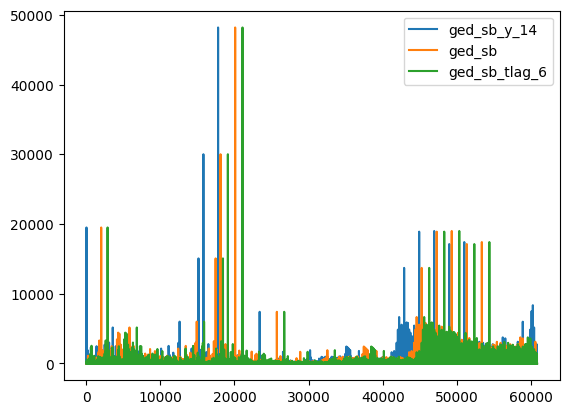

In [348]:
# get all rows that have ged_sb_y_ in the name
all_targets = [col for col in cm_features.columns if col.startswith('ged_sb_y_')]
prediction_window = 14
target = f'ged_sb_y_{prediction_window}'
all_targets.remove(target)
cm_features.drop(columns=all_targets, inplace=True)
cm_features = cm_features.dropna()  # drop all rows for which ged_sb_y_15 is NAN

# plot target per month
from matplotlib import pyplot as plt

cm_features[target].plot()
cm_features['ged_sb'].plot()
cm_features['ged_sb_tlag_6'].plot()
plt.legend()
plt.show()

In [349]:
cm_features = cm_features.drop(columns=['country', 'gleditsch_ward'])
# drop if exists 'year', 'ccode'
cm_features = cm_features.drop(columns=['year', 'ccode', 'region', 'region23'], errors='ignore')

# cm_features = cm_features.drop(
#     columns=['ged_sb_tlag_2', 'ged_sb_tlag_3', 'ged_sb_tlag_4', 'ged_sb_tlag_5', 'ged_sb_tlag_1', 'ged_sb_tlag_6', ])
# # drop ged_sb, ged_ns, ged_os, acled_sb, acled_sb_ count, acled_os, ged_sb_tsum_24
# cm_features = cm_features.drop(
#     columns=['ged_sb', 'ged_ns', 'ged_os', 'acled_sb', 'acled_sb_count', 'acled_os', 'ged_sb_tsum_24', 'ged_os_tlag_1'])
# # drop splag_1_decay_ged_sb_5, splag_1_decay_ged_os_5, splag_1_decay_ged_ns_5, decay_ged_sb_5, decay_ged_os_5, decay_ged_sb_500, decay_ged_os_100, decay_ged_ns_5, decay_ged_ns_100, decay_acled_sb_5, decay_acled_os_5, decay_acled_ns_5
# cm_features = cm_features.drop(
#     columns=['splag_1_decay_ged_sb_5', 'splag_1_decay_ged_os_5', 'splag_1_decay_ged_ns_5', 'decay_ged_sb_5',
#              'decay_ged_os_5', 'decay_ged_sb_500', 'decay_ged_os_100', 'decay_ged_ns_5', 'decay_ged_ns_100',
#              'decay_acled_sb_5', 'decay_acled_os_5', 'decay_acled_ns_5', 'decay_ged_sb_100'])



In [350]:
# save first 50 rows of the dataset to a new csv file with column names
# cm_features.head(50).to_csv('data/cm_features_first_50.csv', index=True)
# cm_features.head(10)
# prepare dataset for machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

cm_features['date'] = pd.to_datetime(cm_features['date'])
cm_features['country_id'] = cm_features['country_id'].astype('category')
# cm_features

In [351]:
# One-hot encode 'country_id'
if INCLUDE_COUNTRY_ID:
    from sklearn.preprocessing import OneHotEncoder

    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    encoder.fit_transform(cm_features[['country_id']])
    countries_encoded = encoder.transform(cm_features[['country_id']])
    # rename the columns
    countries_encoded = pd.DataFrame(countries_encoded, columns=encoder.get_feature_names_out(['country_id']))
    countries_encoded = countries_encoded.drop(columns='country_id_1')  # drop country_id_1
    # drop na 

    # countries_encoded
    # merge the encoded features with the original dataset
    cm_features = pd.concat([cm_features, countries_encoded], axis=1)
    cm_features = cm_features.dropna()
cm_features.head(10)

,month_id,country_id,ged_sb,ged_ns,ged_os,acled_sb,acled_sb_count,acled_os,ged_sb_tsum_24,wdi_sp_pop_totl,...,region23_Northern America,region23_Northern Europe,region23_South America,region23_South-Eastern Asia,region23_Southern Africa,region23_Southern Asia,region23_Southern Europe,region23_Western Africa,region23_Western Asia,region23_Western Europe
0,121,1,0,0,0,0,0,0,0,752897,...,0,0,1,0,0,0,0,0,0,0
1,121,2,0,0,0,0,0,0,0,408360,...,0,0,1,0,0,0,0,0,0,0
2,121,3,0,0,0,0,0,0,0,1256210,...,0,0,0,0,0,0,0,0,0,0
3,121,4,0,0,12,0,0,0,0,19275292,...,0,0,1,0,0,0,0,0,0,0
4,121,7,0,0,0,0,0,0,0,32165766,...,0,0,1,0,0,0,0,0,0,0
5,121,8,0,0,0,0,0,0,0,6949139,...,0,0,1,0,0,0,0,0,0,0
6,121,9,0,0,0,0,0,0,0,148003411,...,0,0,1,0,0,0,0,0,0,0
7,121,10,0,0,0,0,0,0,0,13128619,...,0,0,1,0,0,0,0,0,0,0
8,121,11,0,0,0,0,0,0,0,10210185,...,0,0,1,0,0,0,0,0,0,0
9,121,12,0,0,0,0,0,0,150,3951288,...,0,0,1,0,0,0,0,0,0,0


In [352]:
# Split the dataset into training and test sets
# prediction_year = 2018
# test(final model evaluation): Jan 2018 - Dec 2018 (12 months)
# Nov 2016 (Nov 2016 month_id 443)    predicts Jan 2018 (Nov 2016 443+3+11=457)
# Oct 2017 (Nov 2016 month_id+11=454) predicts Dec 2018 (Oct 2017 454+3+11=468)
# train_df is until Oct 2016 inclusive 
# test_df is one year from Nov 2016 to Oct 2017 inclusive
# Note: Ideally:
# Oct 2017 454 predicts Jan 2018 457
# Oct 2017 454 predicts Feb 2018 458
# ...
# Oct 2017 454 predicts Dec 2018 468
cut_year = prediction_year - 2  # 2016

features_to_val_oct = pd.Timestamp(year=cut_year - 1, month=10, day=1)  # 2016-Oct-01
features_to_oct = pd.Timestamp(year=cut_year, month=10, day=1)  # 2016-Oct-01

# Splitting the dataset
CREATE_VAL_DS = False
if CREATE_VAL_DS:
    train_df = cm_features[cm_features['date'] <= features_to_val_oct]  # train is till Oct 2015
    validation_df = cm_features[
        (cm_features['date'] > features_to_val_oct) &  # oct 2015 predicts Dec 2016
        (cm_features['date'] <= features_to_oct)]
else:
    train_df = cm_features[cm_features['date'] <= features_to_oct]  # train is till Oct 2016
# test_df is one year from Nov 2016 to Oct 2017 inclusive
test_df = cm_features[
    (cm_features['date'] > features_to_oct) &  # Nov 2016 predicts Jan 2018
    (cm_features['date'] <= pd.Timestamp(year=prediction_year - 1, month=10, day=1))]  # Oct 2017 predicts Dec 2018

In [353]:
print(test_df['date'].unique())
# count number of unique dates
print(test_df['date'].nunique())

<DatetimeArray>
['2019-11-01 00:00:00', '2019-12-01 00:00:00', '2020-01-01 00:00:00',
 '2020-02-01 00:00:00', '2020-03-01 00:00:00', '2020-04-01 00:00:00',
 '2020-05-01 00:00:00', '2020-06-01 00:00:00', '2020-07-01 00:00:00',
 '2020-08-01 00:00:00']
Length: 10, dtype: datetime64[ns]
10


In [315]:
# count number of rows where target is 0
# drop 0 rows from train df 
print(f"Initial count: {train_df[train_df[target] == 0].shape[0]}")
indices = train_df[train_df[target] == 0].index.to_series()
num_to_drop = int(len(indices) * DROP_0_ROWS_PERCENT / 100)
indices_to_drop = indices.sample(n=num_to_drop, random_state=42)
train_df = train_df.drop(indices_to_drop)
print(f"Count after removal: {train_df[train_df[target] == 0].shape[0]}")
test_df.reset_index(drop=True, inplace=True)

Initial count: 46975
Count after removal: 9395


In [316]:
# shuffle the training set
# train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [317]:
# save date column for test_df
test_df_date = test_df['date']
train_df_date = train_df['date']
test_df_country_name = test_df['gw_statename']
train_df_country_name = train_df['gw_statename']
train_df_country_id = train_df['country_id']
test_df_country_id = test_df['country_id']
train_df_month_id = train_df['month_id']
test_df_month_id = test_df['month_id']

test_df = test_df.drop('date', axis=1)
test_df = test_df.drop("country_id", axis=1)
test_df = test_df.drop("gw_statename", axis=1)

if CREATE_VAL_DS:
    val_df_date = validation_df['date']
    val_df_country_id = validation_df['country_id']
    val_df_month_id = validation_df['month_id']
    validation_df = validation_df.drop('date', axis=1)
    validation_df = validation_df.drop("country_id", axis=1)
    validation_df = validation_df.drop("gw_statename", axis=1)

train_df = train_df.drop('date', axis=1)
train_df = train_df.drop("country_id", axis=1)
train_df = train_df.drop("gw_statename", axis=1)

if not INCLUDE_MONTH_ID:
    test_df = test_df.drop('month_id', axis=1)
    train_df = train_df.drop('month_id', axis=1)
    if CREATE_VAL_DS:
        validation_df = validation_df.drop('month_id', axis=1)

print(test_df_month_id.unique())
print("Difference between bechmark and test month_id:")
print(benchmark_model['month_id'].min() - test_df_month_id.max())
print(benchmark_model['month_id'].min() - test_df_month_id.min())

train_df.head(10)

[455 456 457 458 459 460 461 462 463 464 465 466]
Difference between bechmark and test month_id:
3
14


,month_id,ged_sb,ged_ns,ged_os,acled_sb,acled_sb_count,acled_os,ged_sb_tsum_24,wdi_sp_pop_totl,ged_sb_tlag_1,...,region23_Northern America,region23_Northern Europe,region23_South America,region23_South-Eastern Asia,region23_Southern Africa,region23_Southern Asia,region23_Southern Europe,region23_Western Africa,region23_Western Asia,region23_Western Europe
2,121,0,0,0,0,0,0,0,1256210,0,...,0,0,0,0,0,0,0,0,0,0
9,121,0,0,0,0,0,0,150,3951288,0,...,0,0,1,0,0,0,0,0,0,0
10,121,40,0,46,0,0,0,1867,21624311,104,...,0,0,1,0,0,0,0,0,0,0
11,121,0,0,0,0,0,0,0,3097889,0,...,0,0,1,0,0,0,0,0,0,0
12,121,4,0,4,0,0,0,86,8805995,17,...,0,0,0,0,0,0,0,0,0,0
14,121,0,0,0,0,0,0,0,258759,0,...,0,0,0,0,0,0,0,0,0,0
18,121,63,0,44,0,0,0,301,31923117,10,...,0,0,1,0,0,0,0,0,0,0
19,121,0,0,0,0,0,0,0,3079001,0,...,0,0,0,0,0,0,0,0,0,0
21,121,0,0,0,0,0,0,4924,5270825,2541,...,0,0,0,0,0,0,0,0,0,0
25,121,0,0,0,0,0,0,0,252852,0,...,0,1,0,0,0,0,0,0,0,0


In [318]:
X_train = train_df.drop(target, axis=1)
y_train = train_df[target]

if CREATE_VAL_DS:
    X_val = validation_df.drop(target, axis=1)
    y_val = validation_df[target]

X_test = test_df.drop(target, axis=1)
y_test = test_df[target]

In [319]:
print('month_id' in X_train.columns)

True


In [320]:
from sklearn.tree import DecisionTreeRegressor
# Model tuning:
# https://stanfordmlgroup.github.io/ngboost/2-tuning.html#Using-sklearn-Model-Selection
from ngboost.scores import CRPScore, LogScore
from ngboost.distns import Poisson, Normal, MultivariateNormal, Gamma
from ngboost import NGBRegressor

# supress RuntimeWarning for NGBRegressor
import warnings

normal_enabled = True
if normal_enabled:
    n_estimators = 300
else:
    n_estimators = 500
score = CRPScore

bs_max_depth = 5
minibatch_frac = 0.5
base_learner = DecisionTreeRegressor(
    criterion="friedman_mse",
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_depth=bs_max_depth,
    splitter="best",
    random_state=42,
)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print(f"Training NGB with {n_estimators} estimators and {score} score...")
    ngb = NGBRegressor(n_estimators=n_estimators, verbose_eval=10, Dist=Normal if normal_enabled else Poisson,
                       learning_rate=0.01,
                       Score=score,
                       random_state=42,
                       Base=base_learner,
                       minibatch_frac=minibatch_frac,
                       # col_sample=1.0,
                       early_stopping_rounds=None).fit(
        X_train, y_train,
        X_val if CREATE_VAL_DS else X_test, y_val if CREATE_VAL_DS else y_test)
ngb_train_predictions = ngb.predict(X_train)
ngb_predictions = ngb.predict(X_test)
ngb_predictions_dist = ngb.pred_dist(X_test)
# means and stds of the predictions
# mean, std = ngb_predictions_dist.loc, ngb_predictions_dist.scale

ngb_train_predictions = [max(0, pred) for pred in ngb_train_predictions]
ngb_predictions = [max(0, pred) for pred in ngb_predictions]
print("Done!")

Training NGB with 300 estimators and <class 'ngboost.scores.CRPScore'> score...
[iter 0] loss=194.0025 val_loss=164.8756 scale=512.0000 norm=99.9436
[iter 10] loss=179.8993 val_loss=154.4189 scale=512.0000 norm=98.0181
[iter 20] loss=160.1981 val_loss=144.1709 scale=512.0000 norm=94.8488
[iter 30] loss=159.0051 val_loss=133.9902 scale=512.0000 norm=93.3795
[iter 40] loss=142.9171 val_loss=123.6148 scale=512.0000 norm=93.1560
[iter 50] loss=144.4200 val_loss=113.4830 scale=512.0000 norm=94.0196
[iter 60] loss=131.8440 val_loss=103.4180 scale=512.0000 norm=92.3204
[iter 70] loss=117.7912 val_loss=93.5828 scale=512.0000 norm=92.6458
[iter 80] loss=108.2186 val_loss=83.6872 scale=512.0000 norm=94.1939
[iter 90] loss=97.8187 val_loss=73.9706 scale=512.0000 norm=95.4136
[iter 100] loss=93.7207 val_loss=64.3319 scale=512.0000 norm=96.5384
[iter 110] loss=75.4976 val_loss=54.8720 scale=512.0000 norm=100.5293
[iter 120] loss=61.9039 val_loss=45.5516 scale=512.0000 norm=104.9350
[iter 130] loss=

In [321]:
# map predictions to months based on the test_df
test_df['ngb_predictions'] = ngb_predictions
train_df['ngb_predictions'] = ngb_train_predictions

# add date column back to test_df and add to each date shift of 14 months
test_df['date'] = test_df_date + pd.DateOffset(months=prediction_window)
train_df['date'] = train_df_date
test_df['country_id'] = test_df_country_id
train_df['country_id'] = train_df_country_id
test_df['month_id'] = test_df_month_id
train_df['month_id'] = train_df_month_id
test_df['country_name'] = test_df_country_name
train_df['country_name'] = train_df_country_name

# test_df

In [322]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# TODO: Improve metrics and use all metrics from the VIEWS competition
# Calculate RMSE
# train_rmse = sqrt(mean_squared_error(y_train, xg_lss_pred_train))
ngb_train_rmse = sqrt(mean_squared_error(y_train, ngb_train_predictions))

ngb_test_rmse = sqrt(mean_squared_error(y_test, ngb_predictions))
all_zeros_rmse = sqrt(mean_squared_error(y_test, [0] * len(y_test)))
# actuals_rmse = sqrt(mean_squared_error(actuals_model['ged_sb'], predictions))
# benchmark_rmse = sqrt(mean_squared_error(y_test, benchmark_model['outcome']))
actuals_bench_rmse = sqrt(mean_squared_error(actuals_model['ged_sb'], benchmark_model['outcome']))

print("Cm features version:", cm_features_version)
print(f"Prediction year: {prediction_year}")
print(f"Include country_id: {INCLUDE_COUNTRY_ID}")
print(f"Include month_id: {INCLUDE_MONTH_ID}")
print(f"Drop train 0 rows: {DROP_0_ROWS_PERCENT}%")
print(f"Normal distribution: {normal_enabled}")
print(f"Number of estimators: {n_estimators}")
print(f"Score: {str(score)}")

# TODO: Improve metrics and use all metrics from the VIEWS competition
# print(f"XGB [train predictions] RMSE: {train_rmse}")
# print(f"XGB [test predictions]  RMSE YTEST VS PREDICTIONS: {rmse}")

print(f"\nNGB [train predictions] RMSE NGB: {ngb_train_rmse}")
if CREATE_VAL_DS:
    ngb_val_rmse = sqrt(mean_squared_error(y_val, ngb.predict(X_val)))
    print(f"NGB [validation predictions] RMSE NGB: {ngb_val_rmse}")
print(f"NGB [test predictions]  RMSE NGB: {ngb_test_rmse}")
# print(f"RMSE YTEST VS ACTUALS: {actuals_rmse}")
# print(f"RMSE YTEST VS BENCHMARK: {benchmark_rmse}")
print(f"All Zeros: {all_zeros_rmse}")
print(f"\nBenchmark: RMSE ACTUALS VS BENCHMARK: {actuals_bench_rmse}")

Cm features version: 0.7
Prediction year: 2019
Include country_id: False
Include month_id: True
Drop train 0 rows: 80%
Normal distribution: True
Number of estimators: 300
Score: <class 'ngboost.scores.CRPScore'>

NGB [train predictions] RMSE NGB: 596.8323431558024
NGB [test predictions]  RMSE NGB: 138.48210079137854
All Zeros: 208.82312523553537

Benchmark: RMSE ACTUALS VS BENCHMARK: 69.20195745437104


In [323]:
# https://stanfordmlgroup.github.io/ngboost/3-interpretation.html
# DO_IMPORTANCE = False
# # print all feature importance sorted
# feature_importance = bst.get_fscore()
# feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
# print(feature_importance)
# 
# if DO_IMPORTANCE:
#     from xgboost import plot_importance
# 
#     # plot
#     plot_importance(bst, max_num_features=10)
#     plt.show()
# 
#     import shap
# 
#     explainer = shap.TreeExplainer(bst)
#     # dtrain = xgb.DMatrix(X_train, label=y_train)
#     dtrain.feature_names = X_train.columns.tolist()
#     explanation = explainer(dtrain)
#     explanation = shap.Explanation(
#         values=explanation.values,
#         base_values=explanation.base_values,
#         data=explanation.data,
#         feature_names=X_train.columns.tolist()
#     )
#     shap.plots.beeswarm(explanation)
# 


In [324]:
PLOT_STD = True
if PLOT_STD:
    import numpy as np

    # dir(ngb.pred_dist(X_test).scale)
    # ngb.pred_dist(X_test).
    # save std of the predictions
    if normal_enabled:
        ngb_predictions_std = np.sqrt(ngb_predictions_dist.var)
    else:
        sampled_dist = ngb_predictions_dist.sample(1000)
        ngb_predictions_std = sampled_dist.std(axis=0)
        ngb_predictions_max = sampled_dist.max(axis=0)
        ngb_predictions_min = sampled_dist.min(axis=0)
        test_df['ngb_predictions_max'] = ngb_predictions_max
        test_df['ngb_predictions_min'] = ngb_predictions_min

    # add std to test_df
    test_df['ngb_predictions_std'] = ngb_predictions_std


Unique months: [455 456 457 458 459 460 461 462 463 464 465 466]


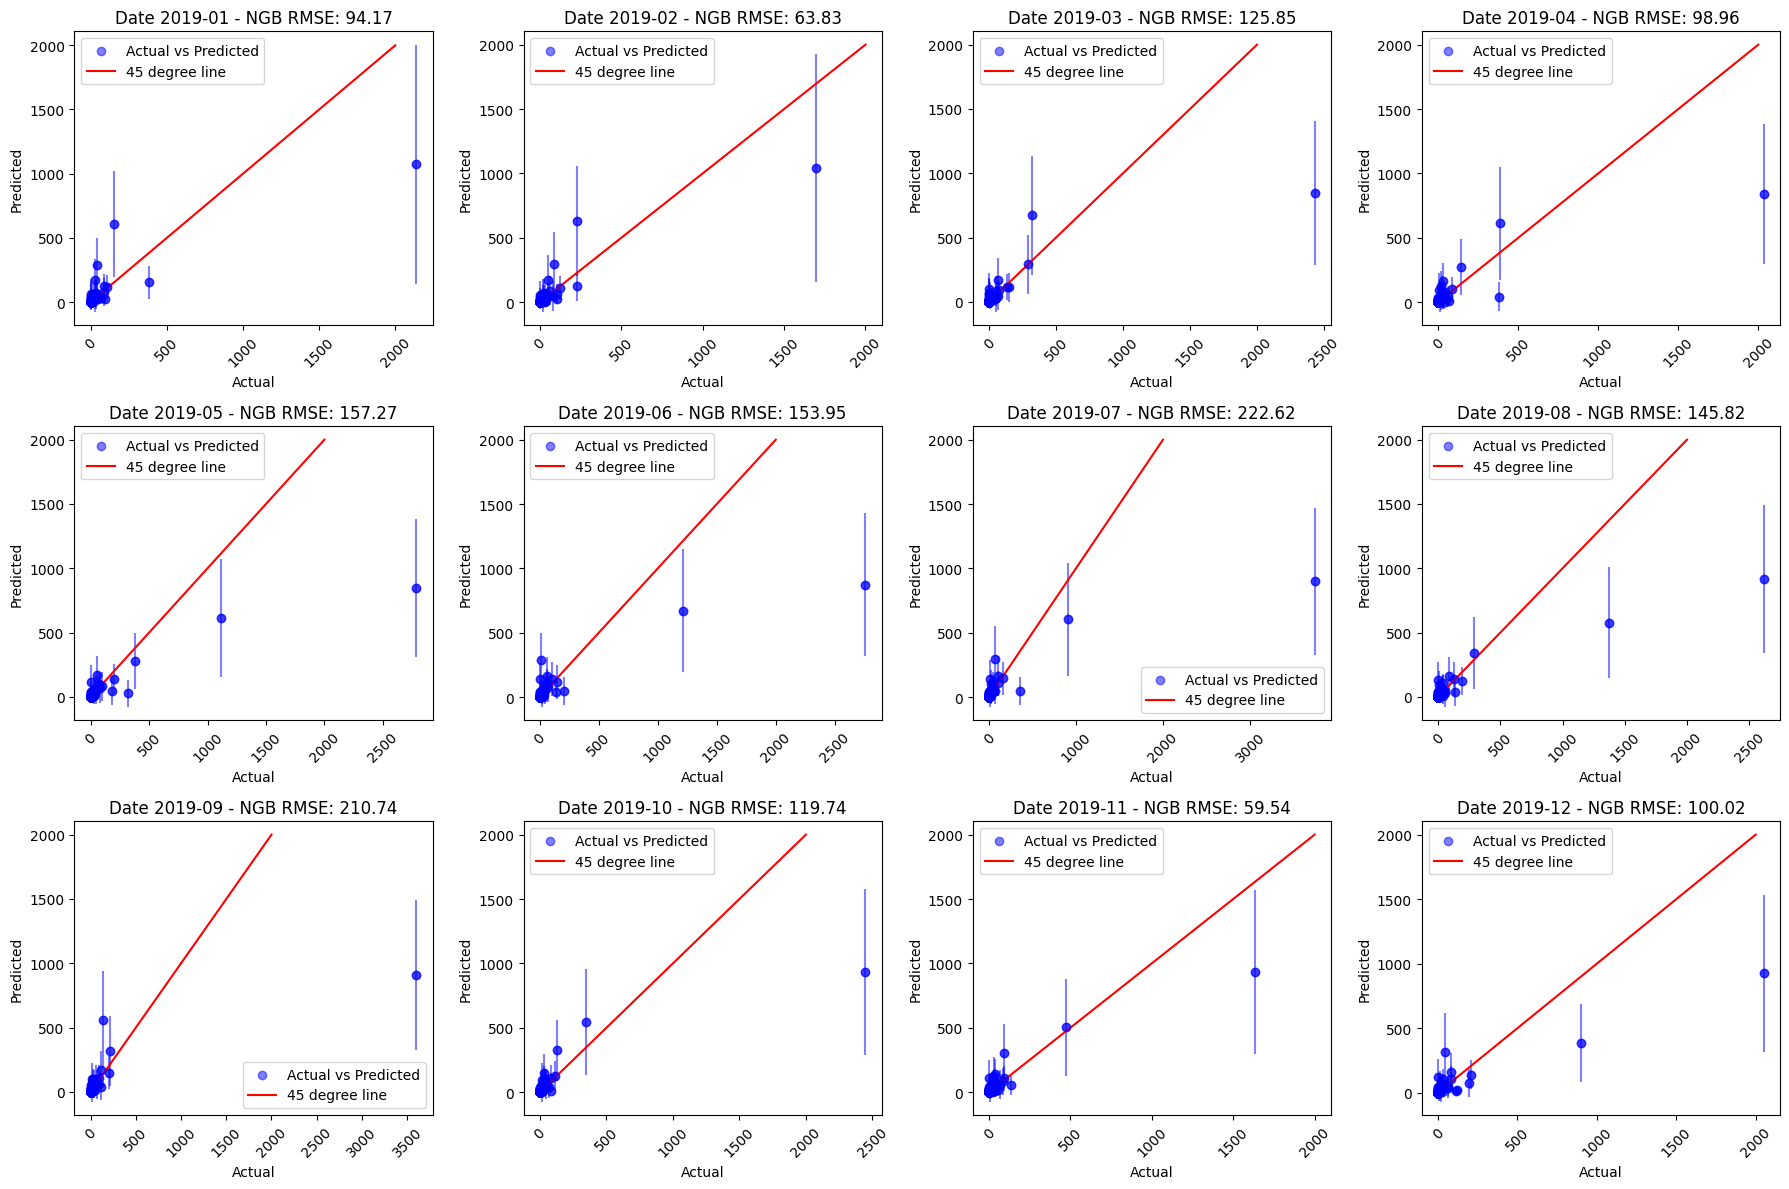

In [325]:
import matplotlib.pyplot as plt

# Assuming test_df is your DataFrame, and 'target' and 'predictions' are columns in it
unique_months = test_df['month_id'].unique()
n_months = len(unique_months)
print("Unique months:", unique_months)

# Calculate the grid size for the subplot (simple square root approximation for a square grid)
grid_size_x = int(n_months ** 0.5) + (1 if n_months % int(n_months ** 0.5) else 0)
grid_size_y = grid_size_x + 1

# print(f'Grid size: {grid_size}')
# Set overall figure size
plt.figure(figsize=(grid_size_x * 6, grid_size_y * 3))  # Adjust the size factors (6, 4) based on your preference

for index, month_id in enumerate(unique_months, start=1):
    this_month = test_df[test_df['month_id'] == month_id]
    mean_sq_error = sqrt(mean_squared_error(this_month[target], this_month['ngb_predictions']))
    current_date = this_month["date"].iloc[0]
    target_month = this_month[target]
    predictions_month = this_month['ngb_predictions']

    # Create subplot for current month
    plt.subplot(grid_size_x, grid_size_y, index)
    plt.scatter(target_month, predictions_month, color='blue', label='Actual vs Predicted', alpha=0.5)

    if PLOT_STD:
        predictions_std_month = this_month['ngb_predictions_std']
        plt.errorbar(target_month, predictions_month, yerr=predictions_std_month, fmt='o', color='blue', alpha=0.5)

    # print current_date in YY/MM format
    print_date = current_date.strftime('%Y-%m')
    plt.title(f'Date {print_date} - NGB RMSE: {mean_sq_error:.2f}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    # plt.xscale('log')
    # plt.yscale('log')
    plt.plot([0, 2000], [0, 2000], color='red', label='45 degree line')
    plt.legend()
    plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [326]:
country_list = pd.read_csv('data/country_list.csv')
# get observations with the highest error
# calculate the error
test_df['error'] = abs(test_df[target] - test_df['ngb_predictions'])
temp_df = test_df.sort_values(by='error', ascending=False)
highest_error_indices = temp_df.head(10).index
del temp_df
# highest_error_indices

# get the highest error
highest_error = test_df.nlargest(30, 'error')
# drop columns that contain 'country_id_'
highest_error = highest_error[highest_error.columns.drop(list(highest_error.filter(regex='country_id_')))]
# add country name
highest_error = highest_error.merge(country_list, on='country_id')
highest_error
# from the test_df get sorted by highest, get the first 10 


,month_id,ged_sb,ged_ns,ged_os,acled_sb,acled_sb_count,acled_os,ged_sb_tsum_24,wdi_sp_pop_totl,ged_sb_tlag_1,...,region23_Western Asia,region23_Western Europe,ngb_predictions,date,country_id,country_name,ngb_predictions_std,error,id,name
0,461,2590,21,21,3327,1034,90,39283,35643418,1697,...,0,0,898.431871,2019-07-01,133,Afghanistan,570.595973,2843.568129,133,Afghanistan
1,463,2690,185,37,3763,967,162,40970,35643418,1730,...,0,0,906.368915,2019-09-01,133,Afghanistan,582.924627,2696.631085,133,Afghanistan
2,459,1475,12,38,1704,614,135,38379,35643418,1530,...,0,0,843.759548,2019-05-01,133,Afghanistan,536.643767,1943.240452,133,Afghanistan
3,460,1697,14,98,2004,849,175,38520,35643418,1475,...,0,0,873.105787,2019-06-01,133,Afghanistan,557.777798,1886.894213,133,Afghanistan
4,462,1730,15,28,2493,848,134,39533,35643418,2590,...,0,0,916.268840,2019-08-01,133,Afghanistan,578.550560,1699.731160,133,Afghanistan
5,457,1734,13,6,1717,743,191,37790,35643418,1012,...,0,0,846.017139,2019-03-01,133,Afghanistan,560.819405,1583.982861,133,Afghanistan
6,464,2394,278,85,3993,960,113,41223,35643418,2690,...,0,0,933.805913,2019-10-01,133,Afghanistan,641.656645,1514.194087,133,Afghanistan
7,458,1530,0,14,1374,580,47,38035,35643418,1734,...,0,0,843.055259,2019-04-01,133,Afghanistan,544.476480,1190.944741,133,Afghanistan
8,466,2368,39,66,2688,687,163,41467,35643418,2301,...,0,0,924.005614,2019-12-01,133,Afghanistan,609.273284,1126.994386,133,Afghanistan
9,455,1225,23,19,1186,757,47,36966,34636207,1731,...,0,0,1072.712286,2019-01-01,133,Afghanistan,932.215146,1065.287714,133,Afghanistan


Max date in training set: 2017-10-01 00:00:00
Min date in test set: 2019-01-01 00:00:00
Expected min date in test set: 2019-01-01 00:00:00
Skipping Guyana as all actual are 0
Skipping Suriname as all actual are 0
Skipping Trinidad and Tobago as all actual are 0
Skipping Venezuela as all actual are 0
Skipping Argentina as all actual are 0
Skipping Bolivia as all actual are 0
Skipping Brazil as all actual are 0
Skipping Chile as all actual are 0
Skipping Paraguay as all actual are 0
Skipping Peru as all actual are 0
Skipping Uruguay as all actual are 0
Skipping Guatemala as all actual are 0
Skipping Mexico as all actual are 0
Skipping Barbados as all actual are 0
Skipping Dominican Republic as all actual are 0
Skipping Haiti as all actual are 0
Skipping Jamaica as all actual are 0
Skipping Costa Rica as all actual are 0
Skipping Cuba as all actual are 0
Skipping El Salvador as all actual are 0
Skipping Honduras as all actual are 0
Skipping Nicaragua as all actual are 0
Skipping Panama as

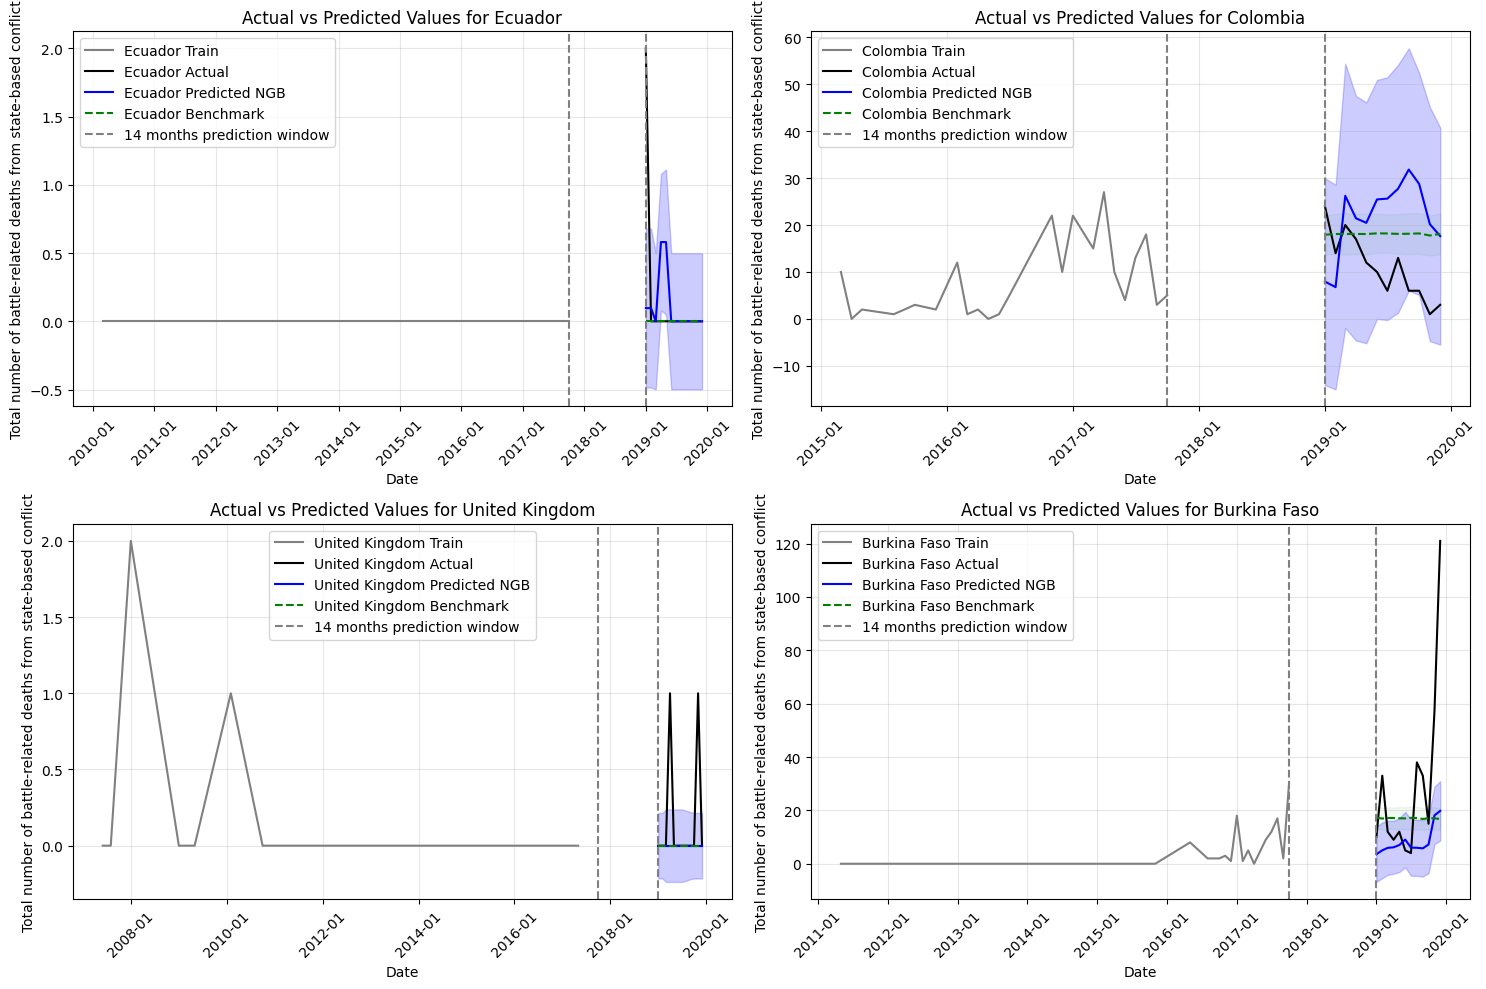

Skipping Guinea as all actual are 0
Skipping Guinea-Bissau as all actual are 0
Skipping Senegal as all actual are 0
Skipping Sierra Leone as all actual are 0
Skipping The Gambia as all actual are 0
Skipping Djibouti as all actual are 0
Skipping Eritrea as all actual are 0
Skipping Mongolia as all actual are 0
Skipping Jordan as all actual are 0
Skipping Kazakhstan as all actual are 0
Skipping Norway as all actual are 0


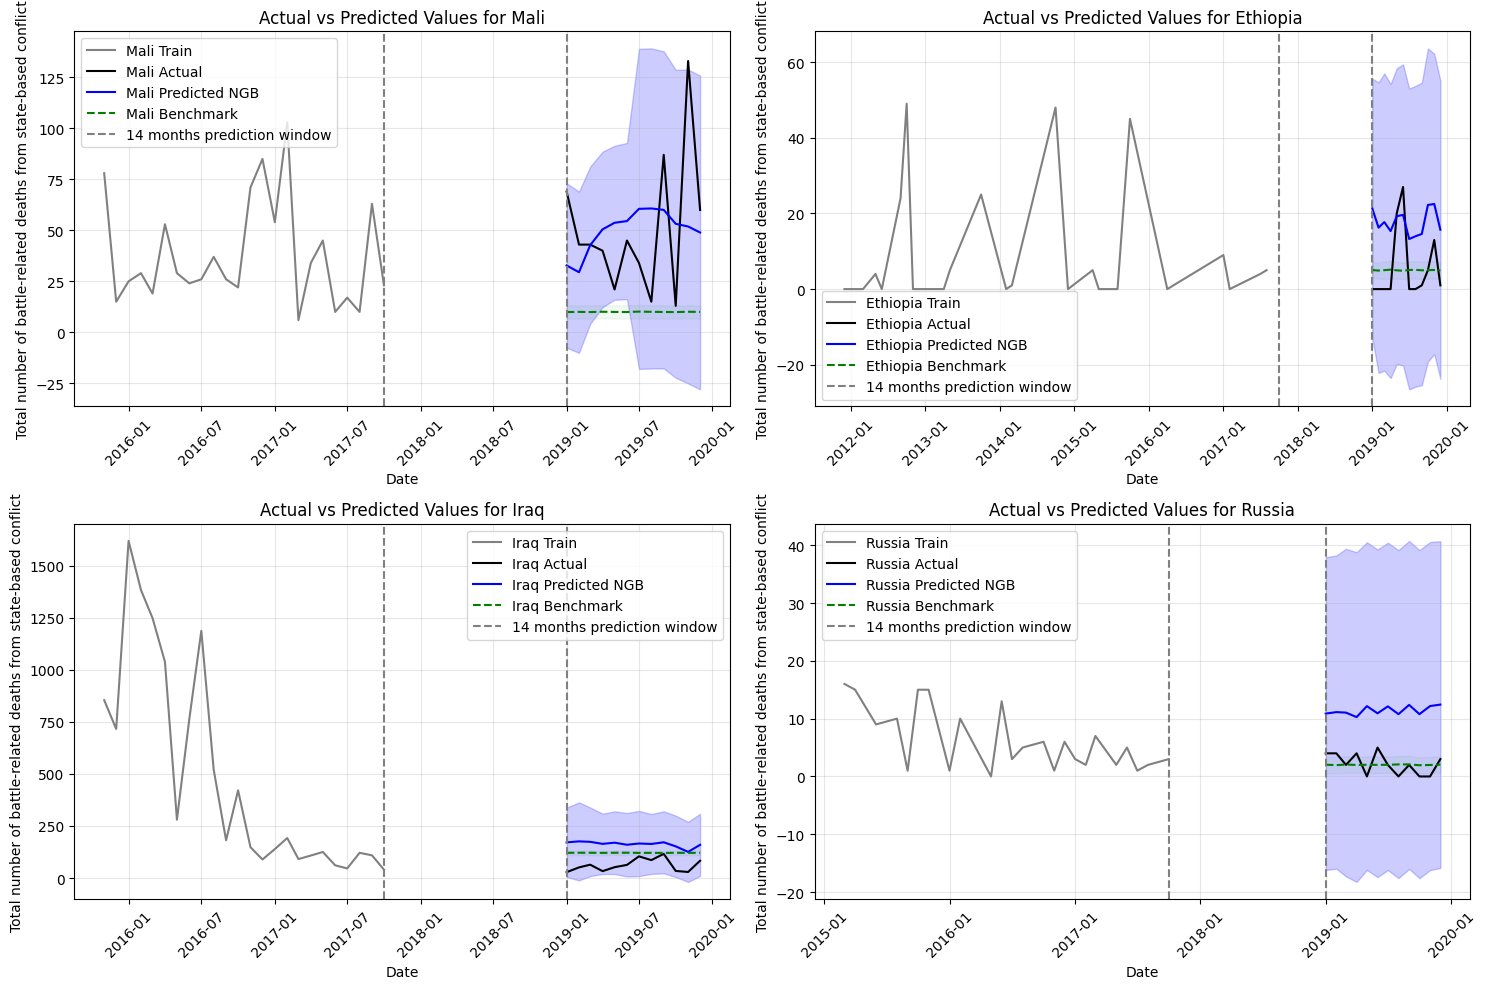

Skipping Sweden as all actual are 0


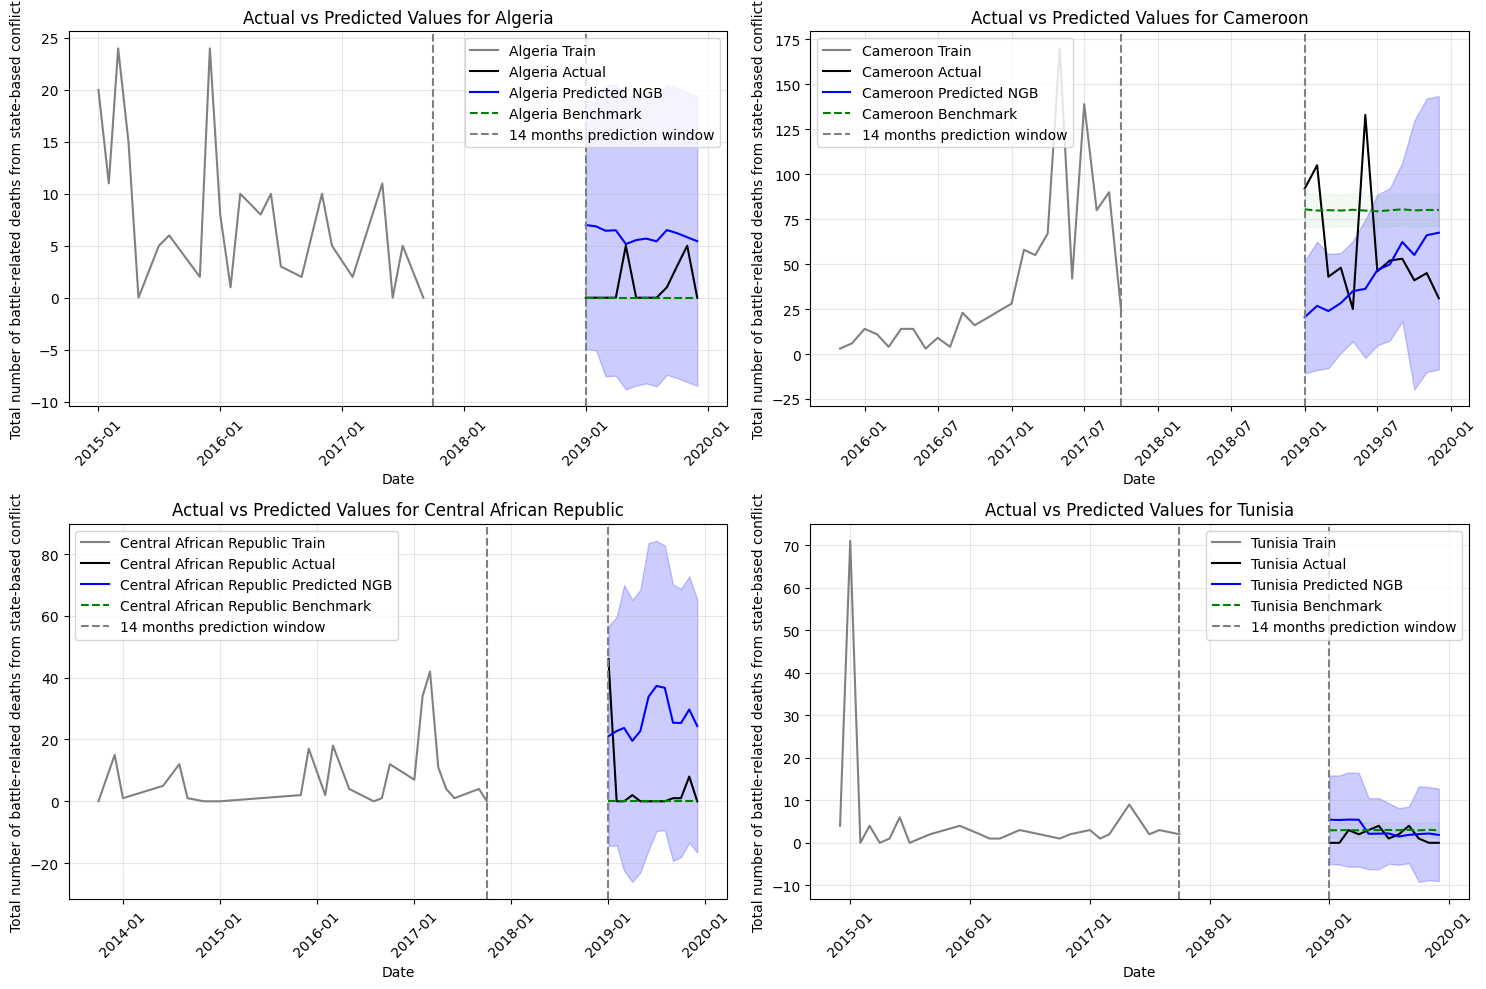

Skipping Benin as all actual are 0
Skipping Equatorial Guinea as all actual are 0
Skipping Togo as all actual are 0
Skipping Albania as all actual are 0
Skipping Bosnia and Herzegovina as all actual are 0
Skipping Croatia as all actual are 0
Skipping Italy as all actual are 0
Skipping Macedonia as all actual are 0
Skipping Malta as all actual are 0
Skipping Bulgaria as all actual are 0
Skipping Cyprus as all actual are 0
Skipping Georgia as all actual are 0
Skipping Greece as all actual are 0
Skipping Lebanon as all actual are 0
Skipping Austria as all actual are 0
Skipping Czech Republic as all actual are 0
Skipping Denmark as all actual are 0
Skipping Hungary as all actual are 0
Skipping Poland as all actual are 0
Skipping Slovakia as all actual are 0
Skipping Slovenia as all actual are 0
Skipping Belgium as all actual are 0
Skipping France as all actual are 0
Skipping Luxembourg as all actual are 0
Skipping Netherlands as all actual are 0
Skipping Switzerland as all actual are 0
Ski

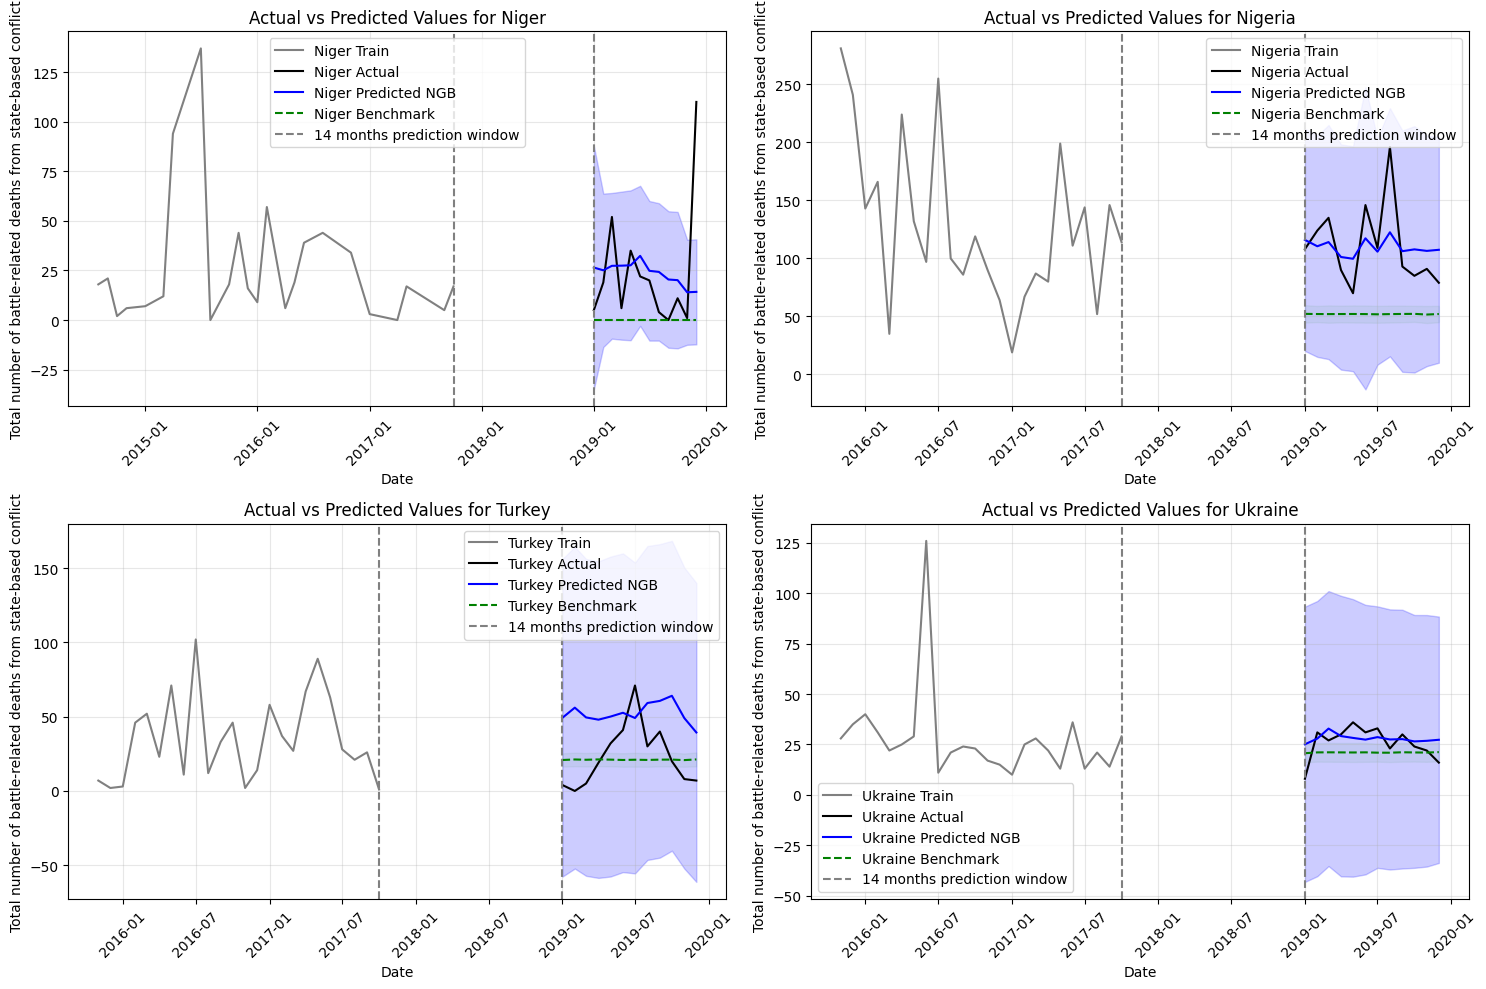

Skipping Maldives as all actual are 0
Skipping Oman as all actual are 0
Skipping Sri Lanka as all actual are 0
Skipping Turkmenistan as all actual are 0
Skipping Uzbekistan as all actual are 0


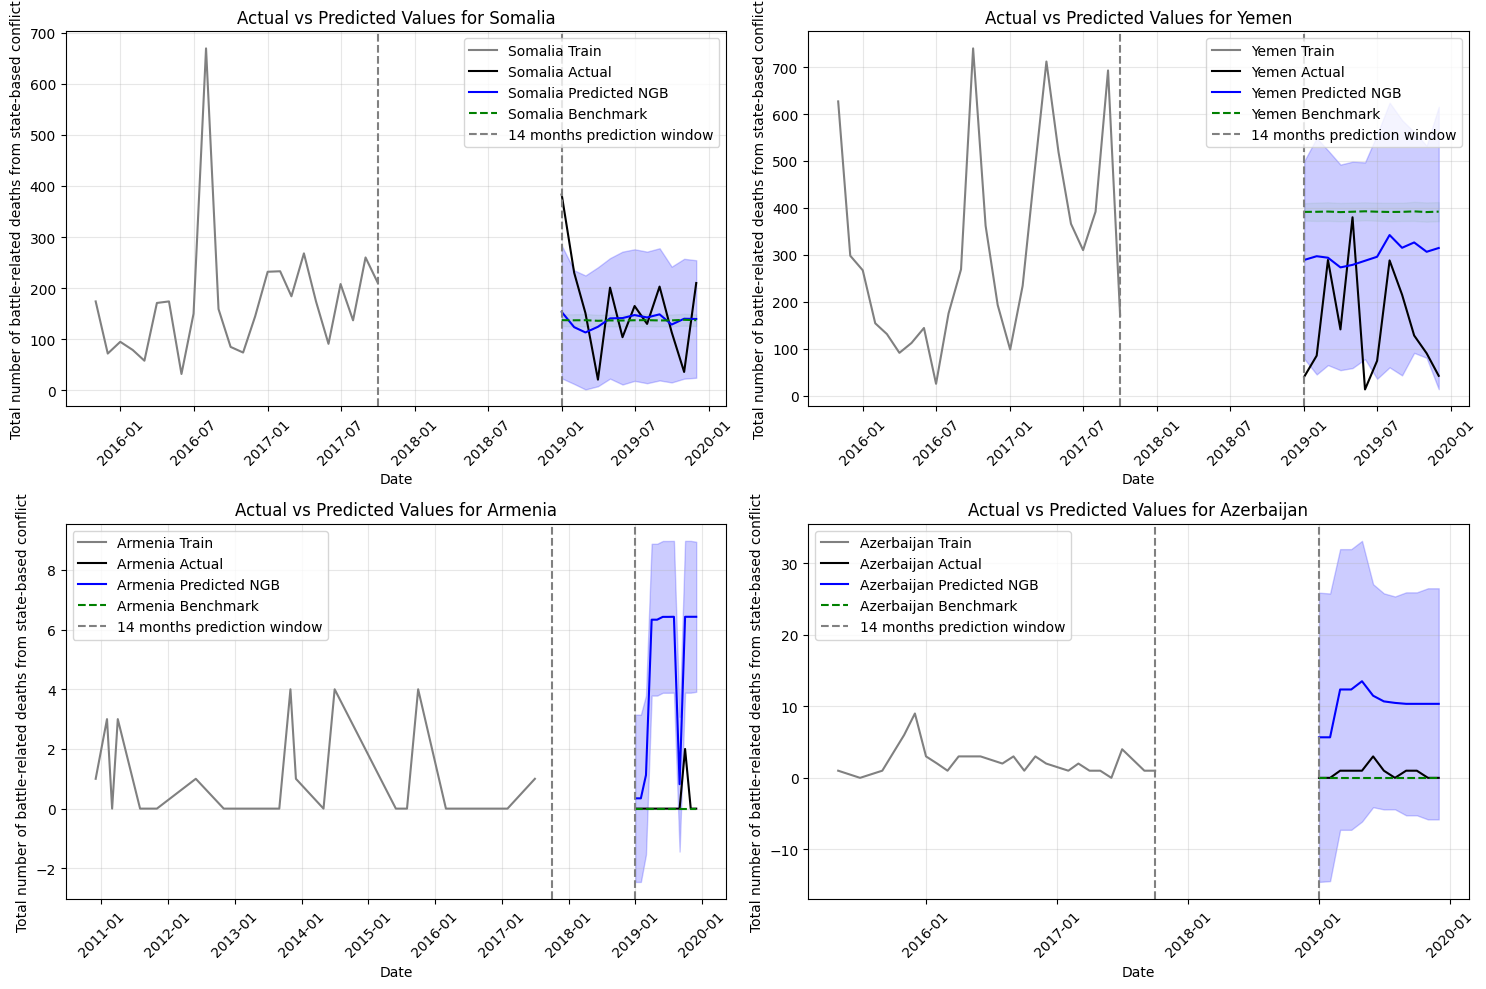

Skipping Bahrain as all actual are 0
Skipping Kuwait as all actual are 0
Skipping Qatar as all actual are 0
Skipping United Arab Emirates as all actual are 0
Skipping Kyrgyzstan as all actual are 0
Skipping Nepal as all actual are 0


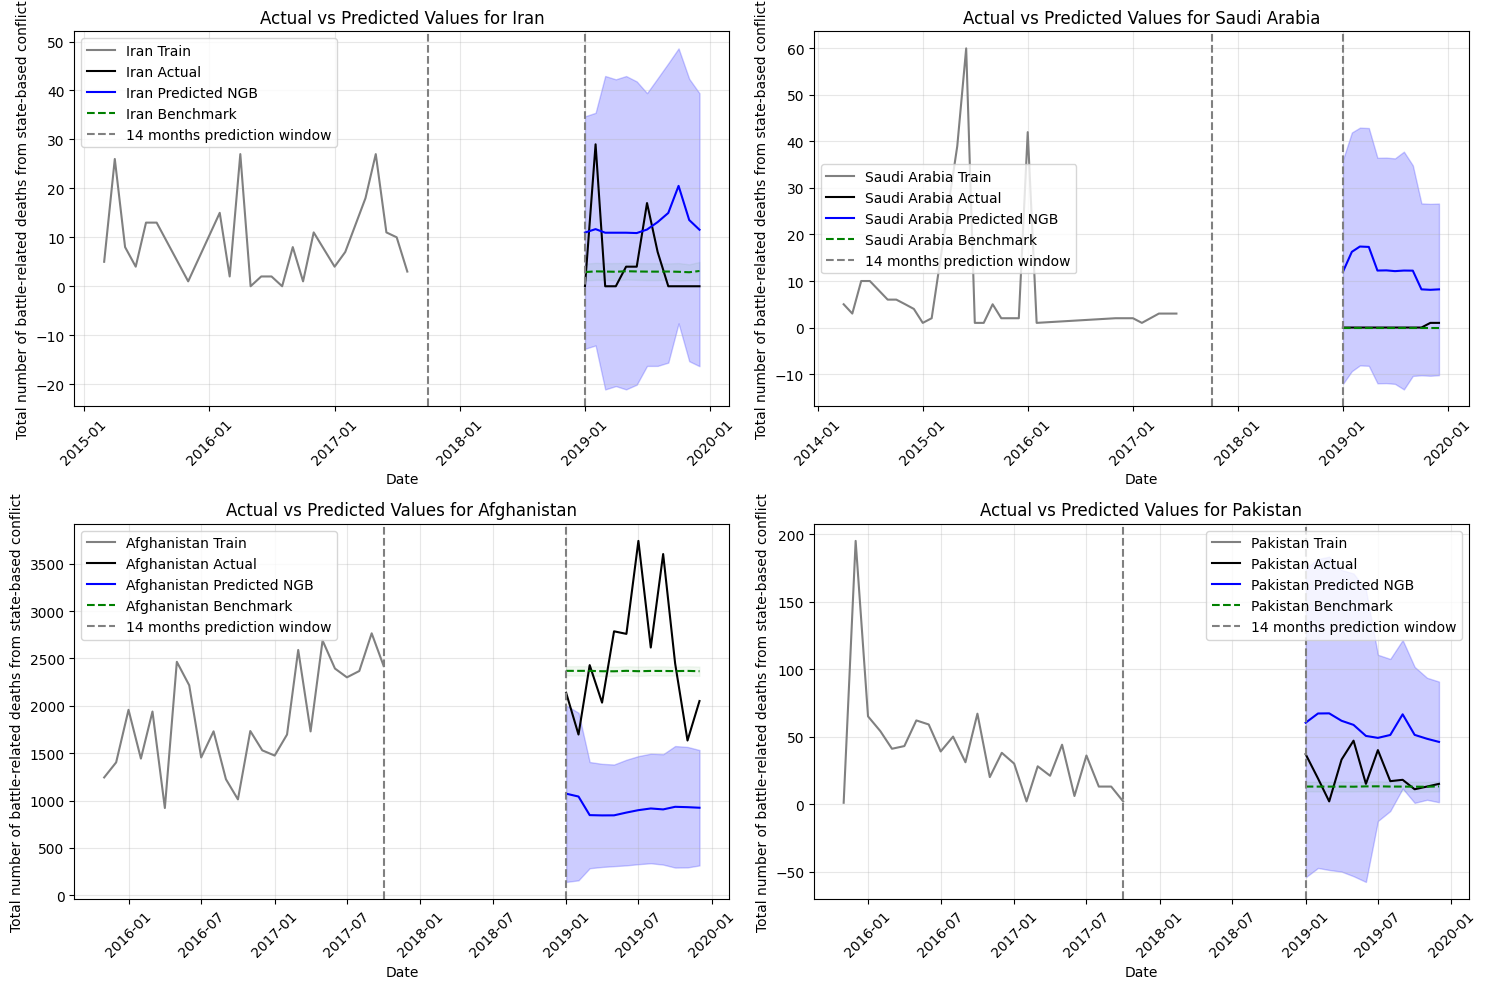

Skipping Bhutan as all actual are 0
Skipping Japan as all actual are 0
Skipping North Korea as all actual are 0
Skipping South Korea as all actual are 0
Skipping Cambodia as all actual are 0
Skipping Laos as all actual are 0


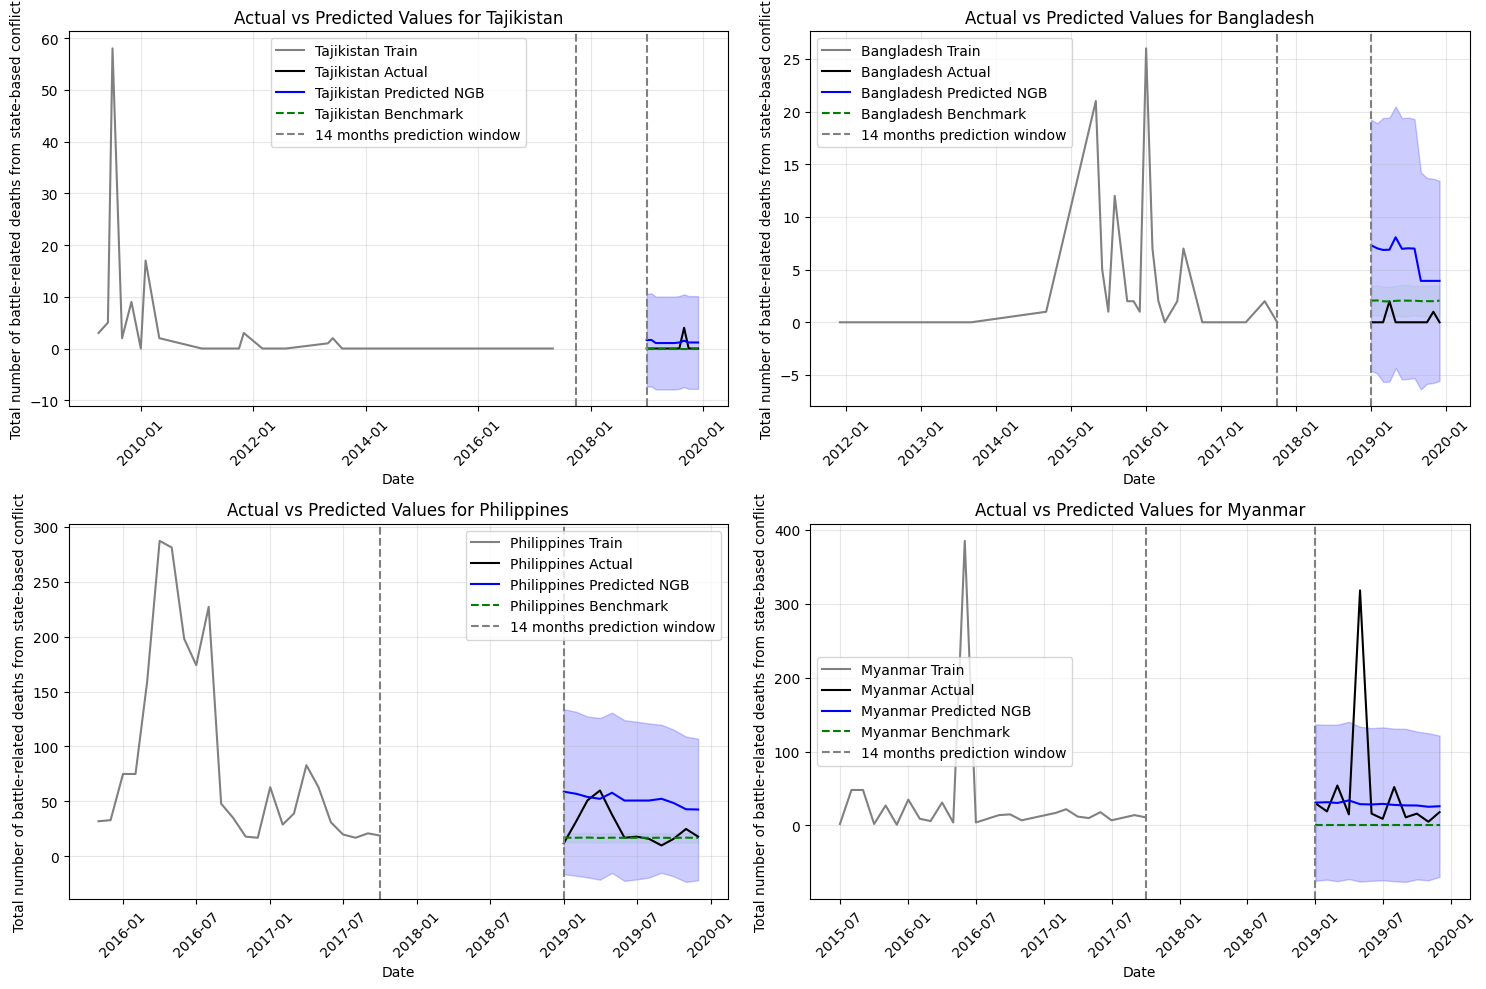

Skipping Vietnam as all actual are 0
Skipping Botswana as all actual are 0
Skipping Zambia as all actual are 0
Skipping Zimbabwe as all actual are 0
Skipping Comoros as all actual are 0
Skipping Lesotho as all actual are 0
Skipping Malawi as all actual are 0


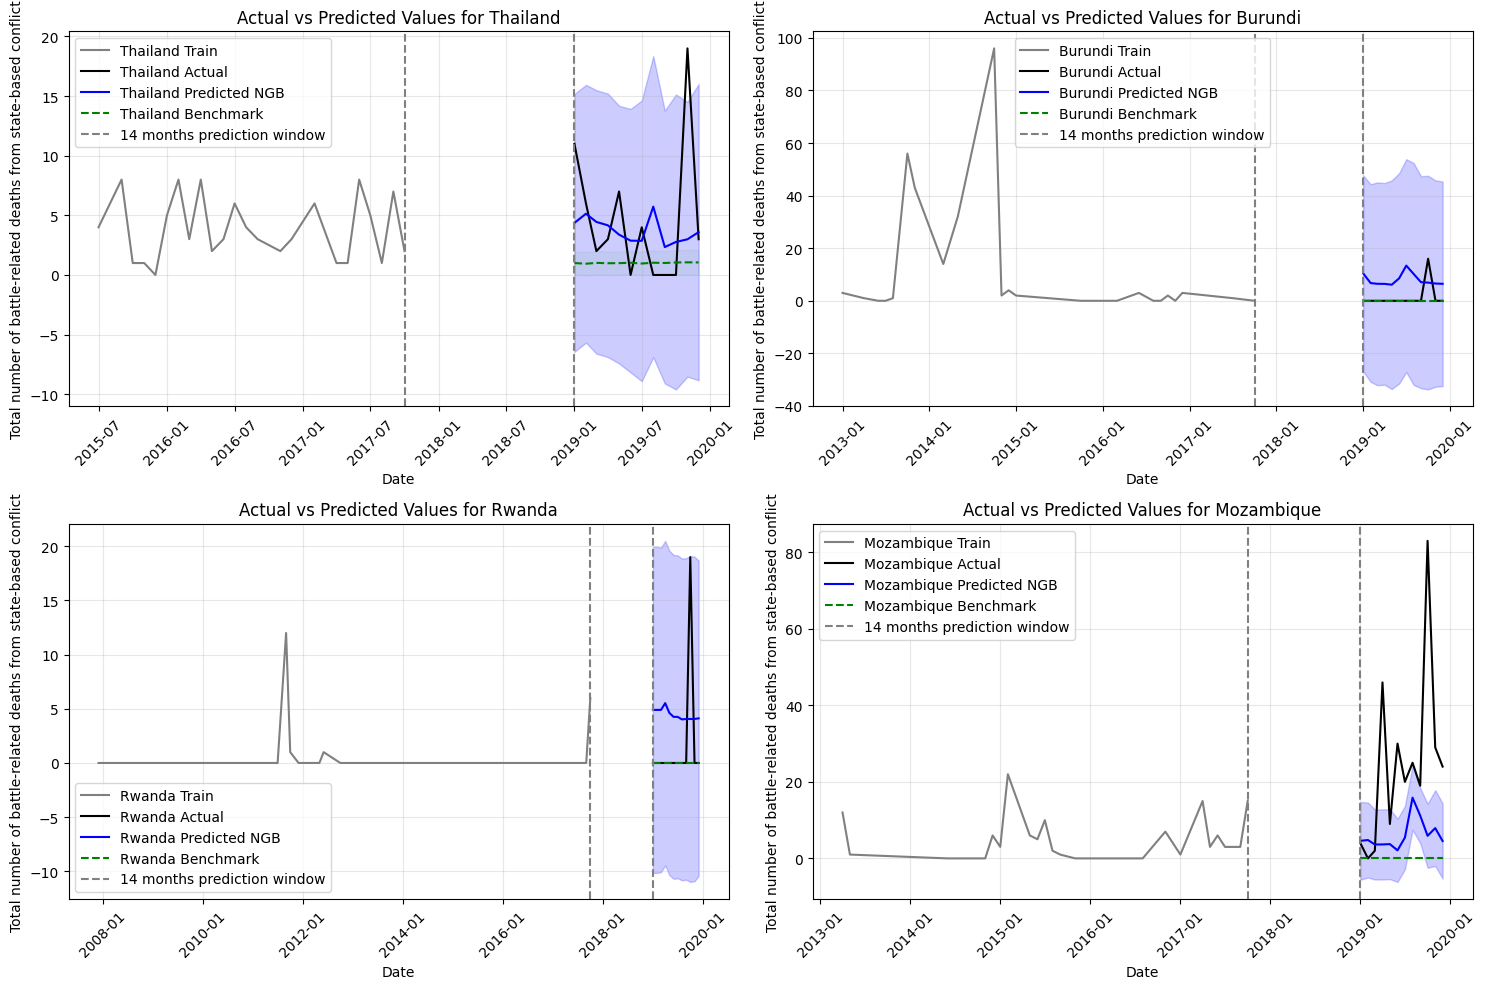

Skipping South Africa as all actual are 0
Skipping Swaziland as all actual are 0
Skipping Congo as all actual are 0
Skipping Fiji as all actual are 0
Skipping Gabon as all actual are 0
Skipping Namibia as all actual are 0
Skipping New Zealand as all actual are 0
Skipping Madagascar as all actual are 0
Skipping Mauritius as all actual are 0
Skipping Timor Leste as all actual are 0
Skipping Australia as all actual are 0
Skipping Papua New Guinea as all actual are 0
Skipping Solomon Is. as all actual are 0
Skipping Canada as all actual are 0
Skipping Germany as all actual are 0
Skipping China as all actual are 0
Skipping Malaysia as all actual are 0
Skipping Singapore as all actual are 0


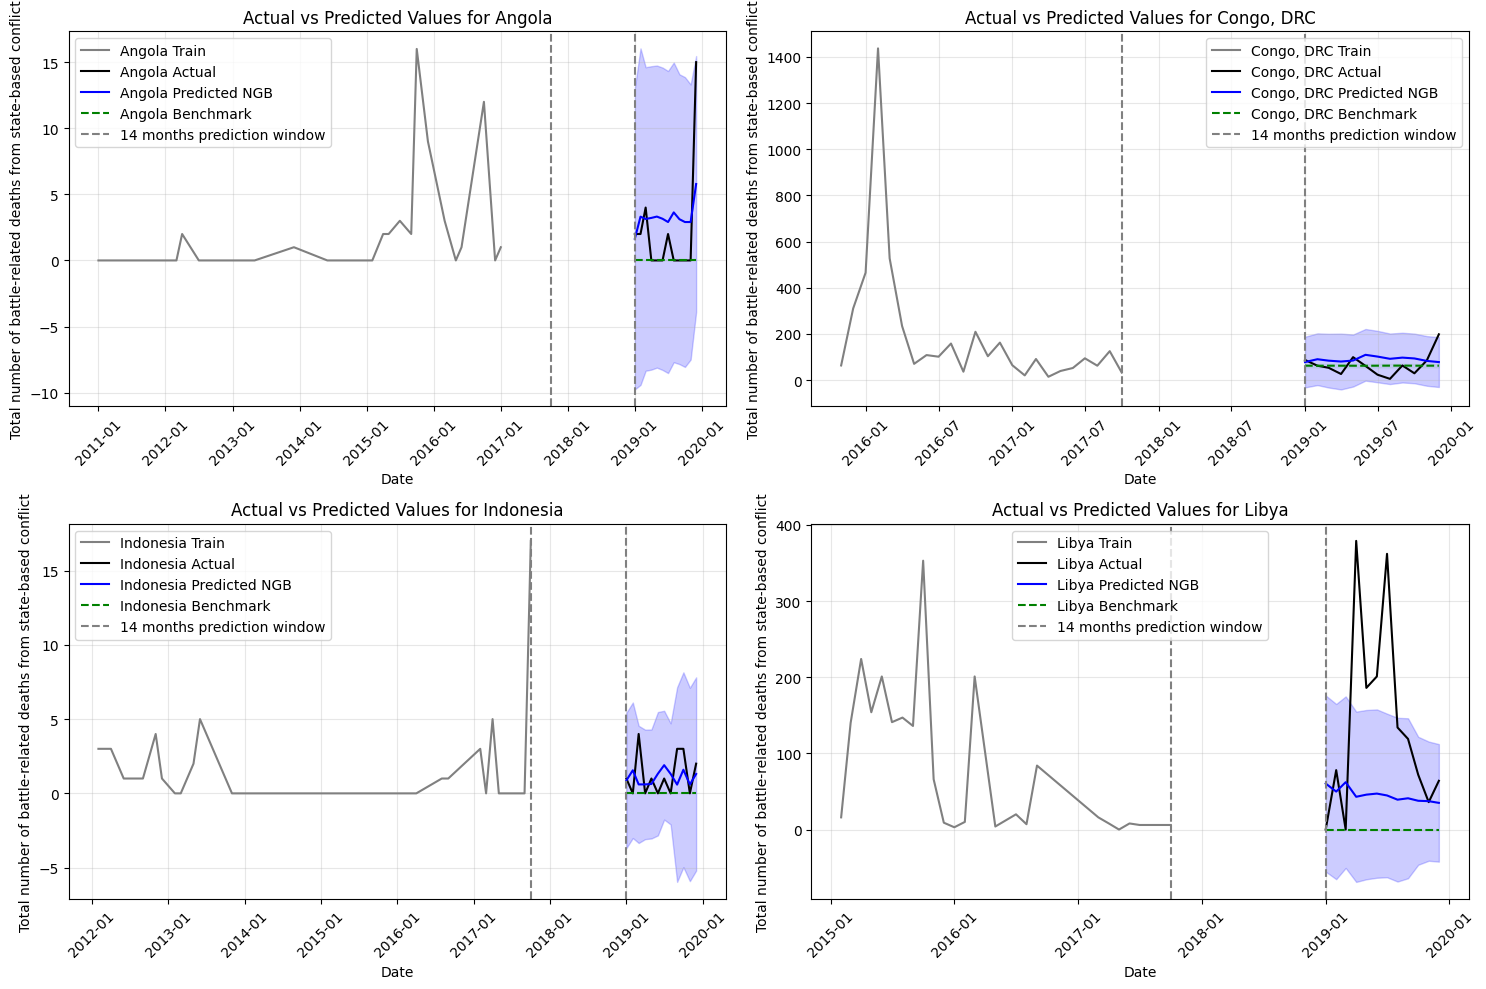

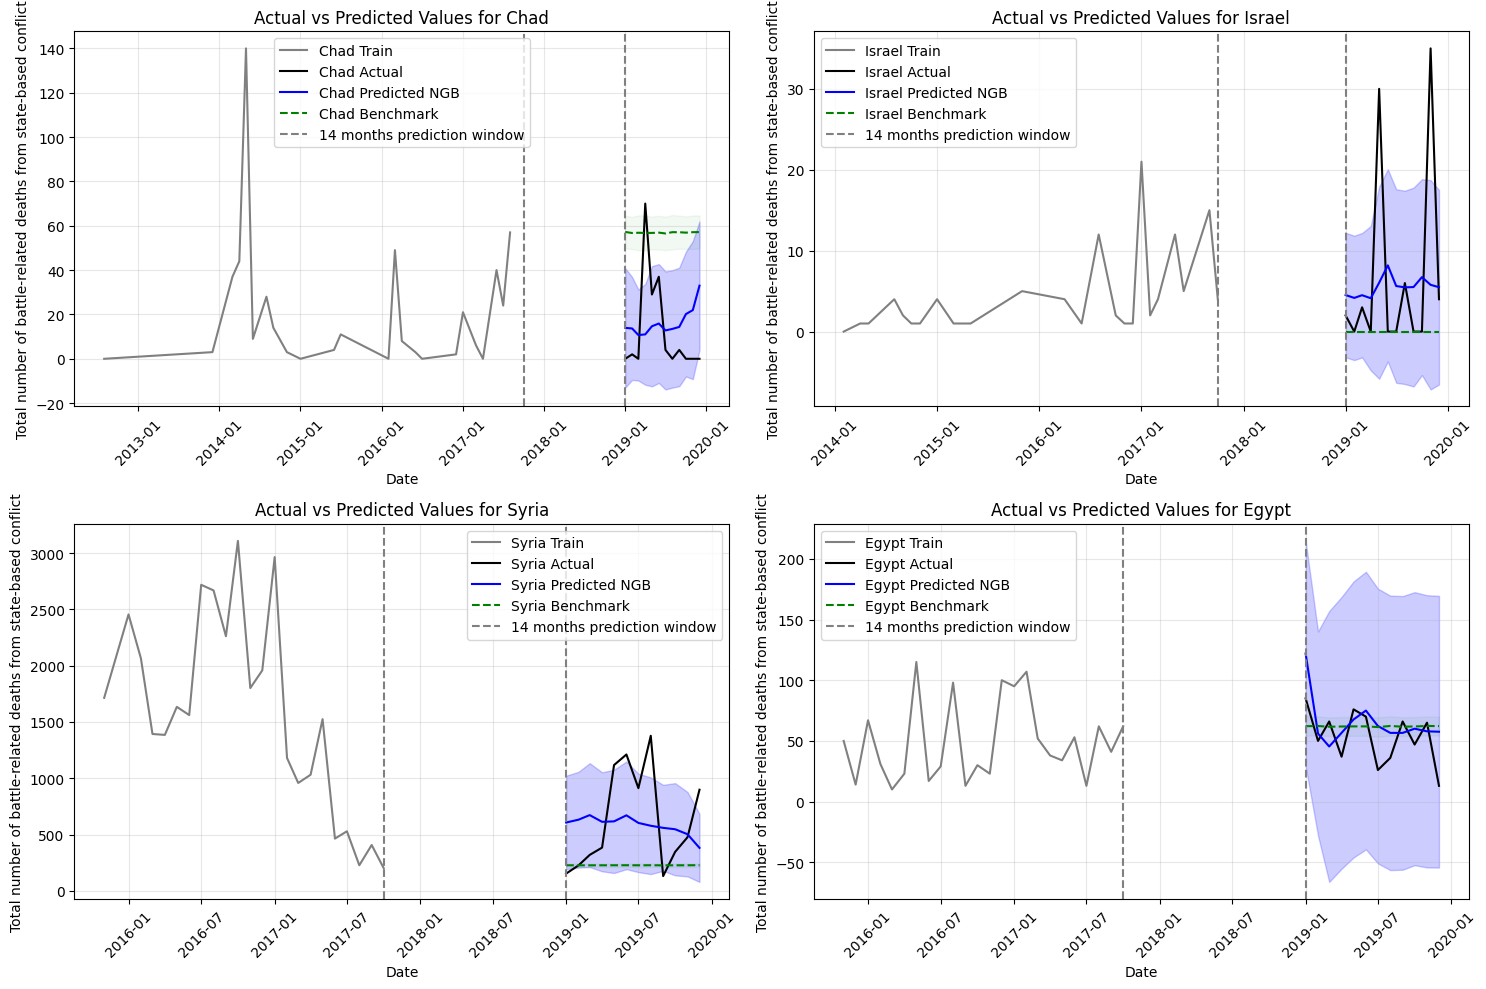

Skipping Montenegro as all actual are 0
Skipping Serbia as all actual are 0
Skipping United States as all actual are 0
Skipping Uganda as all actual are 0
Skipping Tanzania as all actual are 0
Skipping Morocco as all actual are 0
Skipping Mauritania as all actual are 0


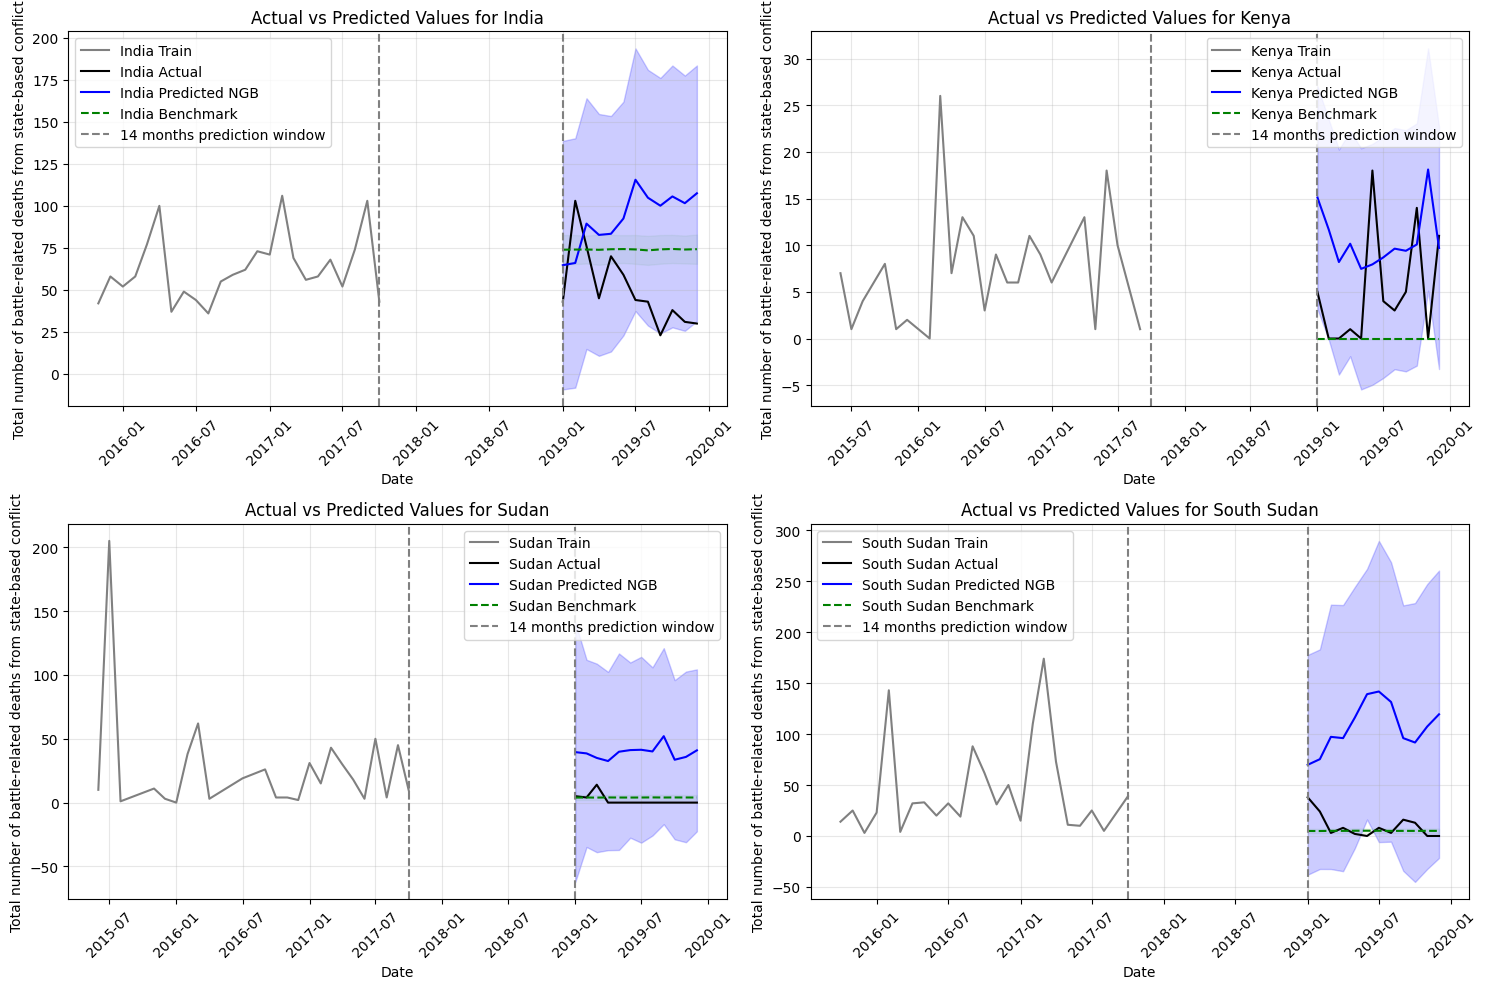

<Figure size 1500x1000 with 0 Axes>

In [327]:
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta

# Load data
country_list = pd.read_csv('data/country_list.csv')
country_ids = test_df['country_id'].unique().tolist()

# Settings
num_plots_per_figure = 4

plt.figure(figsize=(15, 10))  # New figure
plots_added = 0
# Continue looping until all countries have been considered
max_date_train = pd.to_datetime(train_df['date'].max())
min_date_test = pd.to_datetime(test_df['date'].min())
# 1 year buffer because of validation set
expected_min_date_test = max_date_train + relativedelta(years=1 if CREATE_VAL_DS else 0,
                                                        months=prediction_window + 1)  # 15 is window size + 1 is from Sep to Oct
print(f"Max date in training set: {max_date_train}")
print(f"Min date in test set: {min_date_test}")
print(f"Expected min date in test set: {expected_min_date_test}")
# assert the different is exactly 15 months
assert min_date_test == expected_min_date_test

for index, country_id in enumerate(country_ids):

    this_country_test = test_df[test_df['country_id'] == country_id]
    this_country_train = train_df[train_df['country_id'] == country_id]
    # get last 24 months for this_country_train
    this_country_train = this_country_train.tail(24)

    country_name = country_list[country_list['country_id'] == country_id]['name'].values[0]

    # Check if country should be skipped due to no data
    if this_country_test[target].sum() == 0:
        print(f"Skipping {country_name} as all actual are 0")
        continue

    # Prepare the subplot for non-skipped countries
    plt.subplot(2, 2, plots_added + 1)

    # Plotting data
    plt.plot(this_country_train['date'], this_country_train[target], label=f'{country_name} Train', color='gray',
             linestyle='-', marker='')
    plt.plot(this_country_test['date'], this_country_test[target], label=f'{country_name} Actual', color='black',
             linestyle='-', marker='')
    # plt.plot(this_country_test['date'], this_country_test['predictions'], label=f'{country_name} Predicted XGB',
    #          color='red', linestyle='-', marker='')
    plt.plot(this_country_test['date'], this_country_test['ngb_predictions'], label=f'{country_name} Predicted NGB',
             color='blue', linestyle='-', marker='')
    # plot std
    if PLOT_STD:
        month_max_pred = this_country_test['ngb_predictions']
        if not normal_enabled:
            plt.fill_between(this_country_test['date'],
                             this_country_test['ngb_predictions_min'],
                             this_country_test['ngb_predictions_max'],
                             color='blue',
                             alpha=0.2)
        else:
            plt.fill_between(this_country_test['date'],
                             this_country_test['ngb_predictions'] - this_country_test['ngb_predictions_std'],
                             this_country_test['ngb_predictions'] + this_country_test['ngb_predictions_std'],
                             color='blue',
                             alpha=0.2)

    # plt.plot([max_date_train, min_date_test], [-0, -0], color='gray', linestyle='-', marker='', alpha=0.5,
    #          label='15 months prediction window')

    # Benchmark plotting
    benchmark_country = benchmark_model[benchmark_model['country_id'] == country_id]
    plt.plot(benchmark_country['date'], benchmark_country['outcome'], label=f'{country_name} Benchmark',
             color='green', linestyle='--', marker='')
    plt.fill_between(benchmark_country['date'], benchmark_country['outcome'] - benchmark_country['outcome_std'],
                     benchmark_country['outcome'] + benchmark_country['outcome_std'], color='green', alpha=0.05)

    # Adding title and labels
    plt.title(f"Actual vs Predicted Values for {country_name}")
    plt.xlabel("Date")
    # turn dates 90 degrees
    plt.xticks(rotation=45)
    # make ticks more readable
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%Y-%m"))
    # add vertical lines for the training and testing split
    plt.axvline(x=min_date_test, color='gray', linestyle='--', label='14 months prediction window')
    plt.axvline(x=max_date_train, color='gray', linestyle='--')
    plt.ylabel("Total number of battle-related deaths from state-based conflict")
    plt.legend()
    # add light grid
    plt.grid(alpha=0.3)

    # Increment counters
    plots_added += 1

    if plots_added % num_plots_per_figure == 0 or index == len(country_ids) - 1:
        # Adjust layout and display the figure
        plt.tight_layout()
        plt.show()
        plt.figure(figsize=(15, 10))  # New figure
        plots_added = 0

plt.show()


In [328]:
import plotly.graph_objects as go

PLOT_ONE_FIGURE = False
if PLOT_ONE_FIGURE:
    # Assuming country_list, test_df, and train_df are already loaded
    # Creating one figure for all countries
    fig = go.Figure()

    country_ids = test_df['country_id'].unique().tolist()

    for country_id in country_ids:
        # Data for this country
        this_country_test = test_df[test_df['country_id'] == country_id]
        this_country_train = train_df[train_df['country_id'] == country_id]
        country_name = country_list[country_list['country_id'] == country_id]['name'].values[0]

        # Add traces for Train Actual
        fig.add_trace(
            go.Scatter(x=this_country_train['date'], y=this_country_train[target], name=f'{country_name} Train',
                       mode='lines', line=dict(color='gray', width=1))
        )

        # Add traces for Test Actual
        fig.add_trace(
            go.Scatter(x=this_country_test['date'], y=this_country_test[target], name=f'{country_name} Test Actual',
                       mode='lines', line=dict(color='blue', width=1))
        )

        # Add traces for Predicted
        fig.add_trace(
            go.Scatter(x=this_country_test['date'], y=this_country_test['predictions'],
                       name=f'{country_name} Predicted', mode='lines', line=dict(color='red', dash='dot', width=1))
        )

    # Add figure title and adjust layout
    fig.update_layout(
        title_text="Actual vs Predicted Values Across Countries",
        xaxis_title="Date",
        yaxis_title="GED_SB Value",
        legend_title="Legend",
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
    )

    # Show plot
    fig.show()

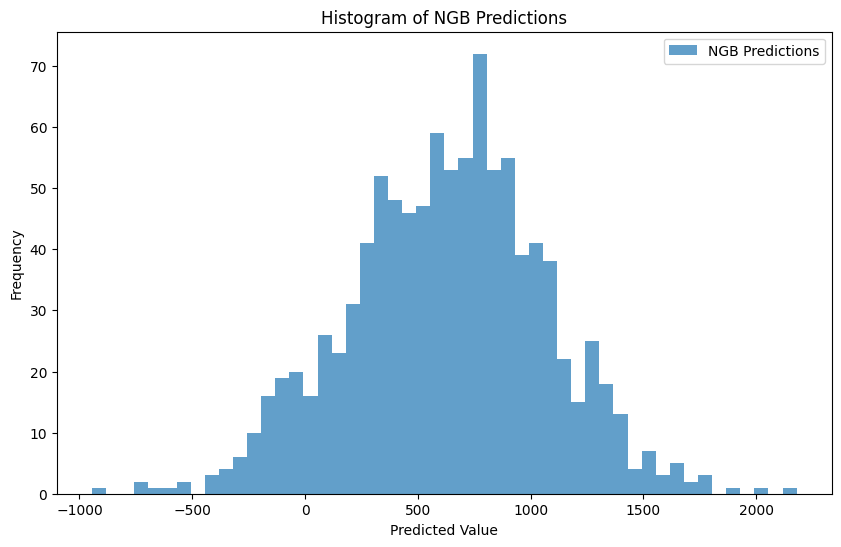

In [329]:
ngb_predictions_sampled = ngb_predictions_dist.sample(1000).T.astype(int)
# 
# concat to test_df
# test_df = pd.concat([test_df, ngb_predictions_sampled], axis=1)


# negative_mask = ngb_predictions_sampled < 0
# # print how many negative values are there
# print(negative_mask.sum().sum()) # 917442
# # print total number of values
# print(negative_mask.size) # 2028000
# # print percentage of negative values
# print(negative_mask.sum().sum() / negative_mask.size) #0.452387573964497
# # sample once more and fill in the previous negative values with values from new distribution
# ngb_predictions_sampled[negative_mask] = ngb_predictions_dist.sample(1000).T[negative_mask]
# # print again how many negative values are there
# negative_mask =  ngb_predictions_sampled < 0
# print(negative_mask.sum().sum())  # 423012

# # set 0 if negative
# # ngb_predictions_sampled = ngb_predictions_sampled.clip(min=0)
# ngb_predictions_sampled = ngb_predictions_sampled
# 
# 
# # plot histogram of the sampled predictions using plt
plt.figure(figsize=(10, 6))
plt.hist(ngb_predictions_sampled[325], bins=50, alpha=0.7, label='NGB Predictions')  # MAX
# plot a dot for the actual value
# plt.scatter([actuals_model['ged_sb'].max()], [0], color='red', label='Actual Value')
# plt.hist(ngb_predictions_sampled[20], bins=50, alpha=0.7, label='NGB Predictions') # MIN
plt.title('Histogram of NGB Predictions')
plt.xlabel('Predicted Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# ngb_predictions_sampled[0]

In [330]:

# len(set(benchmark_model['country_id'].unique()) - set(test_df['country_id'].unique()))
print(benchmark_model['month_id'].unique())
print(test_df['month_id'].unique())
print("Adjusted month_id for predictions:", test_df['month_id'].unique() + 15)
set(benchmark_model['month_id'].unique()) == set(test_df['month_id'].unique() + 15)

[469 470 471 472 473 474 475 476 477 478 479 480]
[455 456 457 458 459 460 461 462 463 464 465 466]
Adjusted month_id for predictions: [470 471 472 473 474 475 476 477 478 479 480 481]


False

In [331]:
test_df.index

RangeIndex(start=0, stop=2028, step=1)

In [332]:
# temp = test_df
# temp.reset_index(inplace=False, drop=False)
# 
# # get row with the highest number of deaths
# temp[temp['predictions'] == temp['predictions'].max()]
# print(temp[temp['predictions'] == temp['predictions'].min()])

# NOTE !!!!
# test_df.reset_index(inplace=True, drop=True)
test_df_edge = test_df.shape[1]
test_df_new = pd.concat([test_df, pd.DataFrame(ngb_predictions_sampled)], axis=1)
ngb_predictions_sampled[12] == test_df_new.iloc[12, test_df_edge:]

# get the row with the highest number of deaths
# actuals_model


# add to test_df_new the actuals based on month_id and country_id
# actuals_model.rename(columns={'ged_sb': 'actuals'}, inplace=True)
# test_df_new.merge(actuals_model[['month_id', 'country_id', 'actuals']], on=['month_id', 'country_id'])

# drop level 0 and index columns
# test_df.drop(columns=['level_0', 'index'], inplace=True, errors='ignore')
# test_df_new

0      True
1      True
2      True
3      True
4      True
       ... 
995    True
996    True
997    True
998    True
999    True
Name: 12, Length: 1000, dtype: bool

In [333]:
# actuals_model.rename(columns={'ged_sb': 'actuals'}, inplace=True)
# actuals_model.set_index(['month_id', 'country_id'], inplace=True)
# test_df_new.set_index(['month_id', 'country_id'], inplace=True)

In [334]:
# actuals_model.rename(columns={'ged_sb': 'actuals'}, inplace=True)
# test_df_new.reset_index(inplace=True, drop=True)
# actuals_model.reset_index(inplace=True, drop=True)


# drop actuals if it exists
# test_df_new = test_df_new.drop(columns='actuals', errors='ignore')

# join actuals to test_df_new
# test_df_new = test_df_new.join(actuals_model['actuals'], how='left')
# test_df_new.reset_index(inplace=True)
# actuals_model.reset_index(inplace=True)
# test_df_new
# actuals_model['actuals']
# test_df_new.head(10)
# test_df_new.head(1000)

In [335]:
print(list(test_df_new.columns).index(target))
print(len(test_df_new.columns))
print(test_df_edge)
test_df_new.head(100)[['month_id', 'country_id', target, 'ngb_predictions']]

126
1158
158


,month_id,country_id,ged_sb_y_14,ngb_predictions
0,455,1,0.0,0.000000
1,455,2,0.0,0.000000
2,455,3,0.0,0.000000
3,455,4,0.0,2.728528
4,455,7,0.0,0.000000
...,...,...,...,...
95,455,121,0.0,3.183490
96,455,122,0.0,2.216786
97,455,123,0.0,0.000000
98,455,124,40.0,289.032119


In [336]:
# test_df_edge = test_df_new.shape[1]
# test_df_new = pd.concat([test_df_new, pd.DataFrame(ngb_predictions_sampled)], axis=1)
# ngb_predictions_sampled[1] == test_df_new.iloc[1, test_df_edge:]

In [337]:
# get id of test_df_new[target].max()
indices_to_plot = [test_df_new[target].idxmax(), test_df_new[target].idxmin()]
indices_to_plot.extend(highest_error_indices)

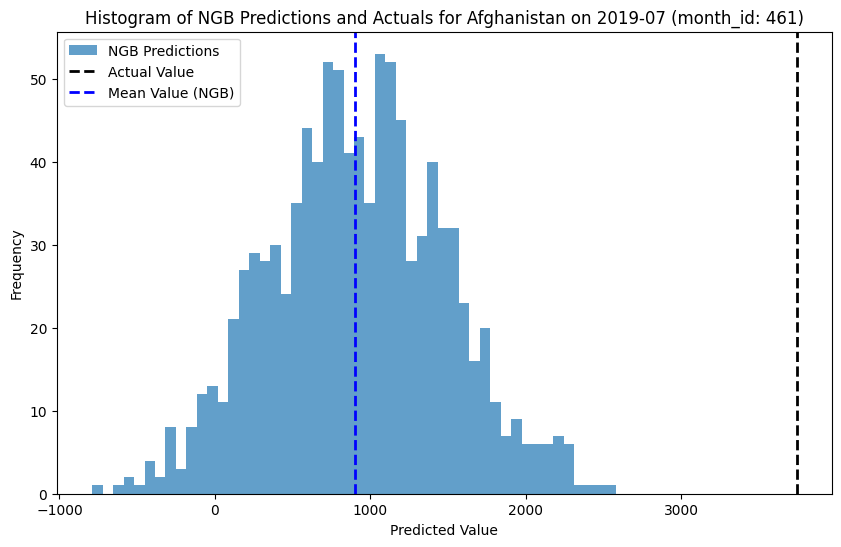

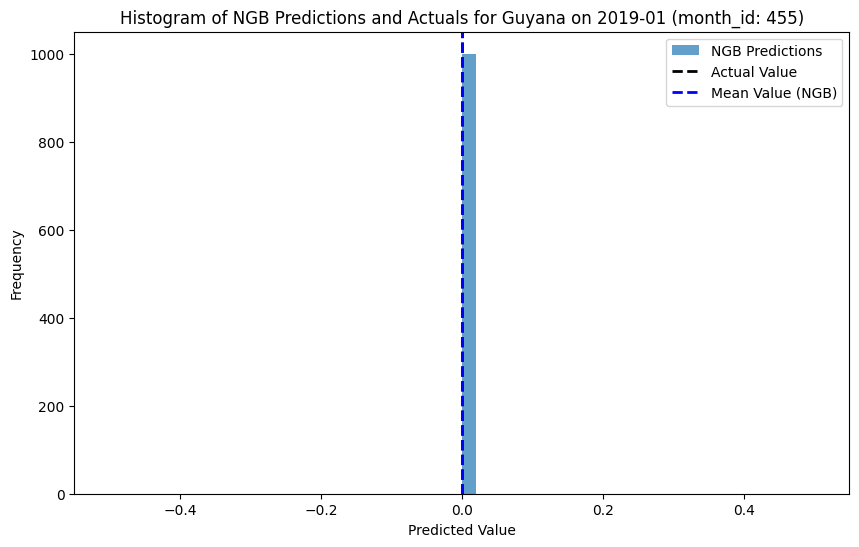

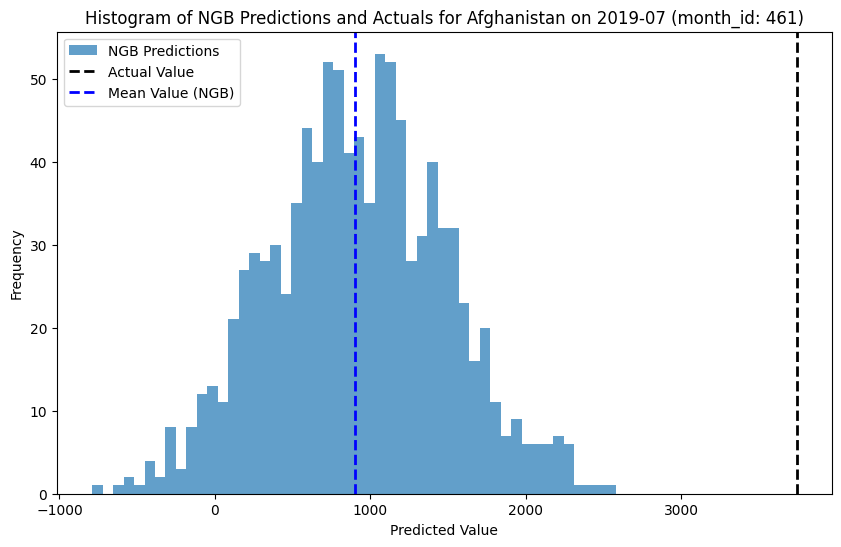

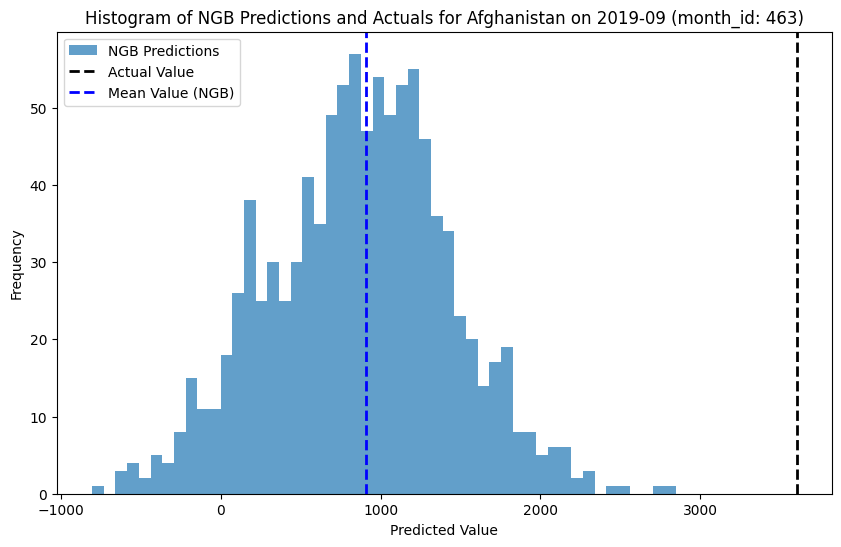

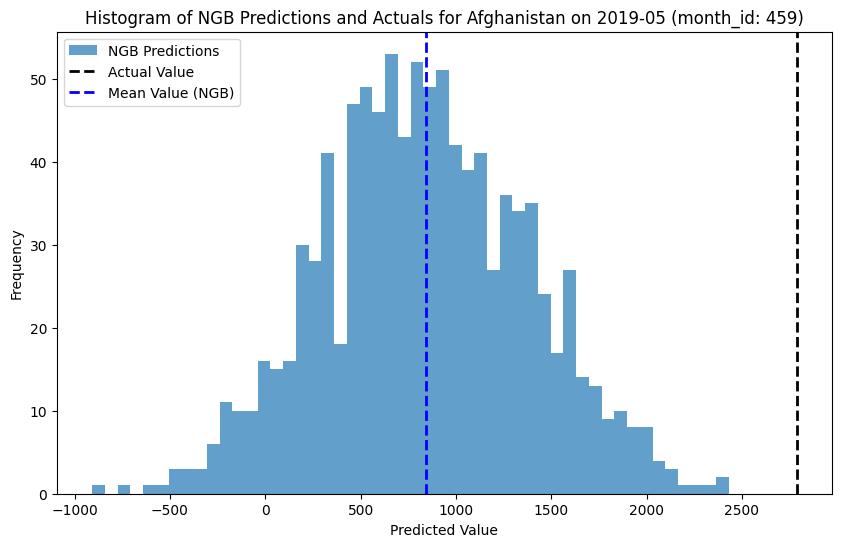

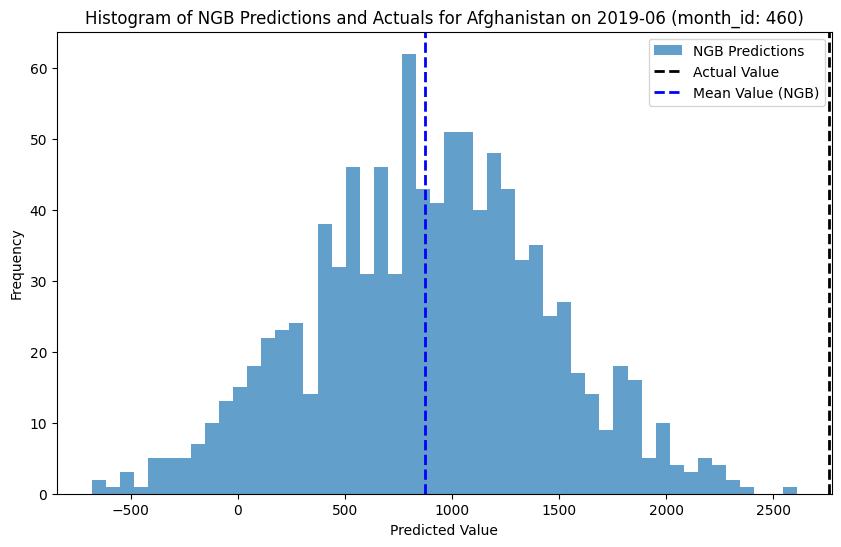

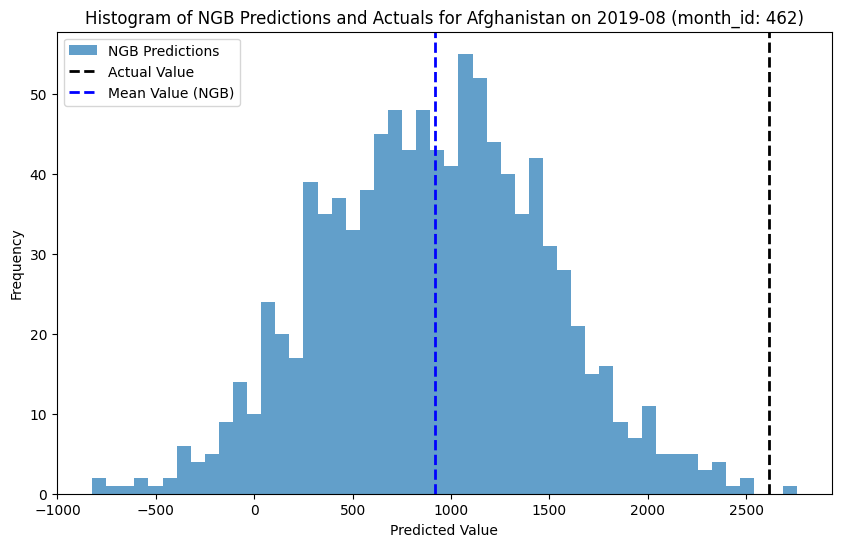

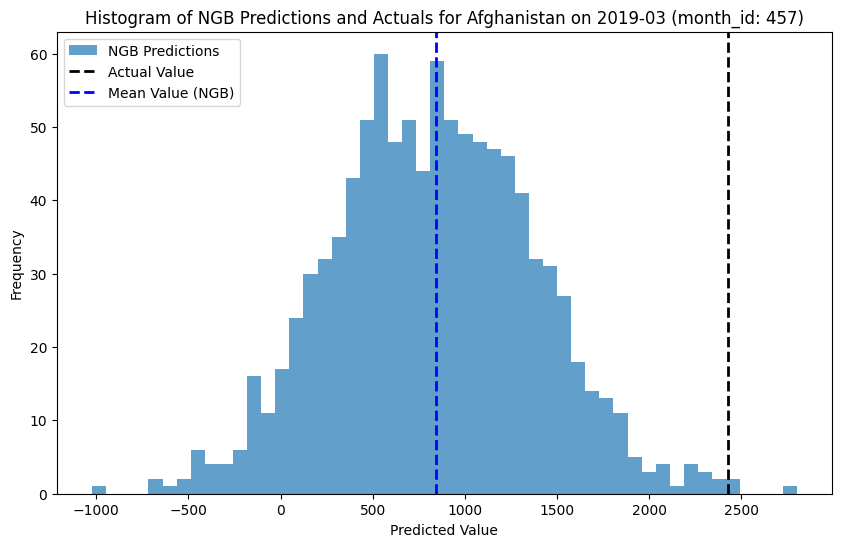

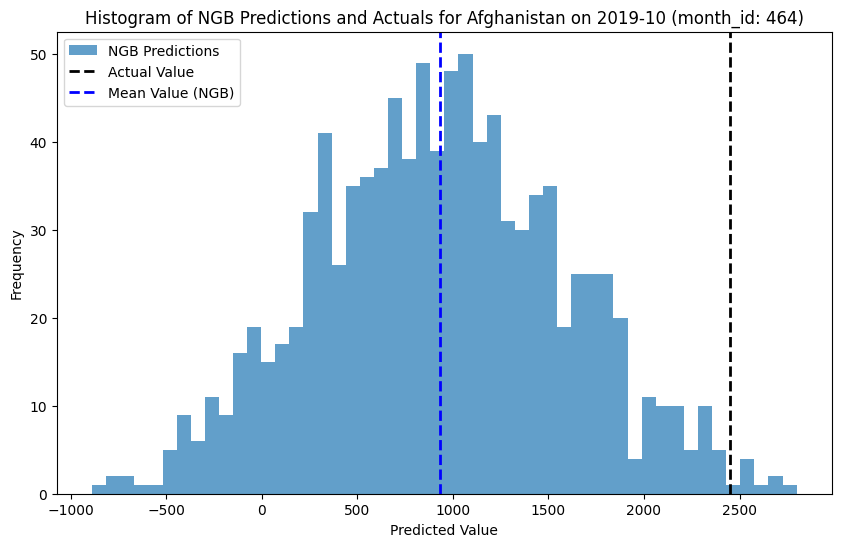

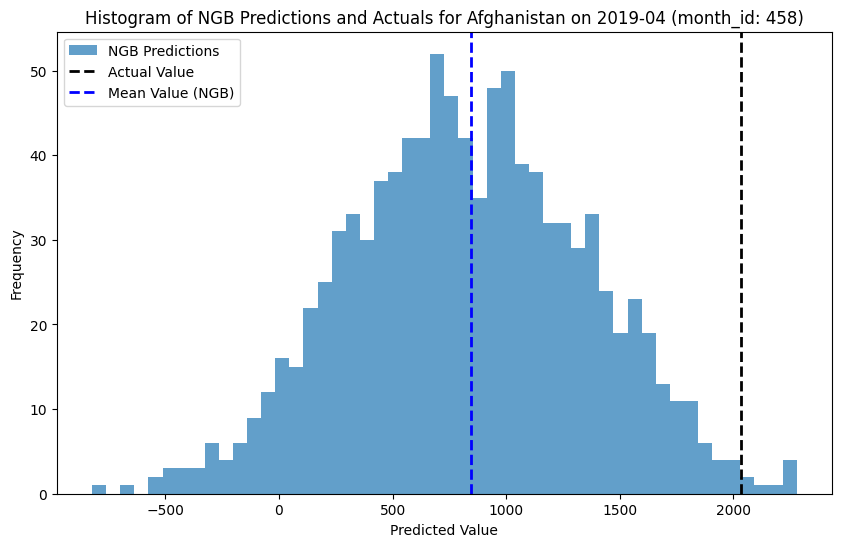

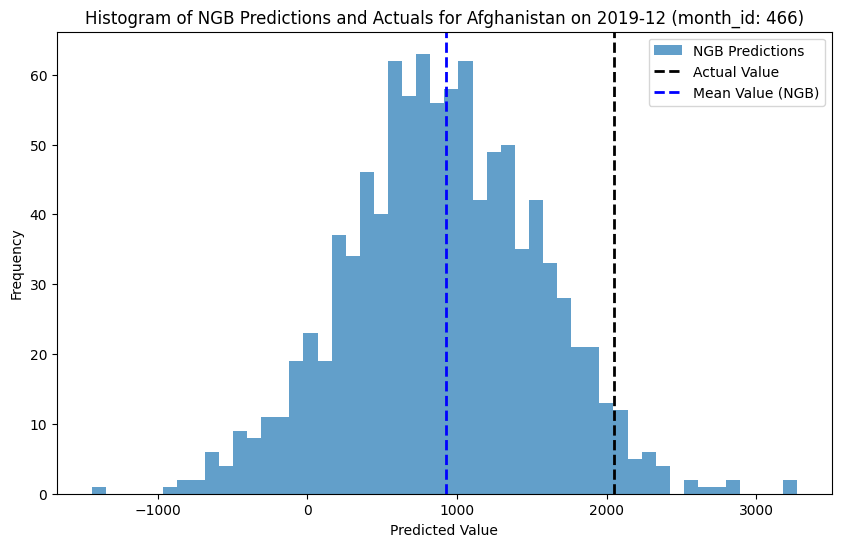

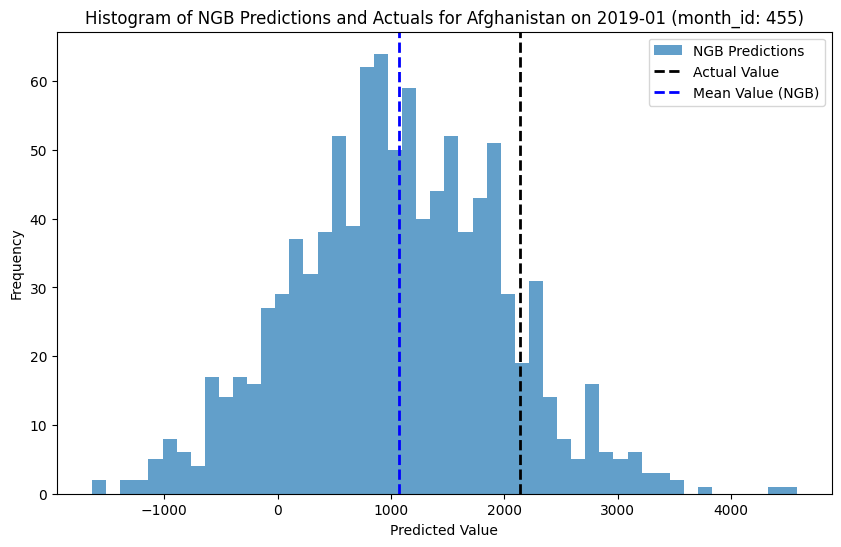

In [338]:

for index_id in indices_to_plot:
    rowww = test_df_new.iloc[[index_id]]
    actual_pred = rowww[target].values[0]
    hist_data_temp = rowww.iloc[:, test_df_edge:].values[0]
    # keep only samples that are in 95% confidence interval

    # Plot histogram of the sampled predictions using plt
    plt.figure(figsize=(10, 6))
    plt.hist(hist_data_temp, bins=50, alpha=0.7, label='NGB Predictions')

    # Plot vertical lines for actual value, mean value, and other relevant predictions
    plt.axvline(x=actual_pred, color='black', linestyle='dashed', linewidth=2, label='Actual Value')
    plt.axvline(x=rowww['ngb_predictions'].values[0], color='blue', linestyle='dashed', linewidth=2,
                label='Mean Value (NGB)')
    # plt.axvline(x=rowww['predictions'].values[0], color='red', linestyle='dashed', linewidth=2, label='XGBoost Prediction')
    formatted_date = rowww['date'].dt.strftime('%Y-%m').values[0]
    country_name = rowww['country_name'].values[0]
    plt.title(
        f'Histogram of NGB Predictions and Actuals for {country_name} on {formatted_date} (month_id: {int(rowww["month_id"].values[0])})')
    plt.xlabel('Predicted Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

In [339]:
test_df_new[test_df_new[target] == test_df_new[target].max()]['ngb_predictions']

1121    898.431871
Name: ngb_predictions, dtype: float64

In [340]:
rowww[['month_id', 'country_id', target, 'ngb_predictions']]

,month_id,country_id,ged_sb_y_14,ngb_predictions
107,455,133,2138.0,1072.712286


In [341]:
dist_name = 'normal' if normal_enabled else 'poisson'
prediction_year

2019

In [342]:
if SAVE_PREDICTIONS:

    # Save predictions
    import numpy as np
    import os

    # TODO: for countries that are in actuals but not in the predictions, add them to the predictions with 0
    #  test_df['country_id'].unique()
    #  actuals_model['country_id'].unique()
    missing_countries = set(benchmark_model['country_id'].unique()) - set(test_df_new['country_id'].unique())

    # save predictions to a csv file
    # for each month for each country create 20 draws of the prediction named outcome
    # the structure of the file should be month_id, country_id, draw, outcome
    new_predictions_list = []
    all_countries = set(test_df_new['country_id'].unique()).union(missing_countries)
    for month_id in test_df_new['month_id'].unique():
        for country_id in all_countries:
            this_country_month = test_df_new[
                (test_df_new['month_id'] == month_id) & (test_df_new['country_id'] == country_id)]

            if country_id in missing_countries:
                outcomes = np.zeros(1000)
            else:
                outcomes = this_country_month.iloc[:, test_df_edge:].values[0]

                # remove all values smaller than 0
                non_negatives = outcomes[outcomes >= 0]
                negative_counts = np.sum(outcomes < 0)

                if negative_counts > 0:
                    # Sample from the non-negative distribution to replace negative values
                    # We assume the distribution of non-negatives is suitable for sampling
                    sampled_values = np.random.choice(non_negatives, size=negative_counts)
                    outcomes[outcomes < 0] = sampled_values

                assert all(outcomes >= 0), "There are still negative values in the outcomes"

            new_predictions_list.extend([{
                'month_id': month_id + prediction_window,  # adjust for prediction window
                'country_id': country_id,
                'draw': draw,
                'outcome': outcome
            } for draw, outcome in enumerate(outcomes, start=0)])

    # set month_id, country_id, draw as int and outcome as float
    new_predictions = pd.DataFrame(new_predictions_list)
    new_predictions['month_id'] = new_predictions['month_id'].astype(int)
    new_predictions['country_id'] = new_predictions['country_id'].astype(int)
    new_predictions['draw'] = new_predictions['draw'].astype(int)
    new_predictions['outcome'] = new_predictions['outcome'].astype(int)
    # set index to month_id, country_id, draw
    new_predictions.set_index(['month_id', 'country_id', 'draw'], inplace=True)
    # create folder if it does not exist recursively
    folder = f"submission/ng_boost_cm_v{cm_features_version}_pw_{prediction_window}_{dist_name}_d_{DROP_0_ROWS_PERCENT}_n_{n_estimators}_s_{score.__name__.lower()}_c_{str(INCLUDE_COUNTRY_ID)[0]}_m_{str(INCLUDE_MONTH_ID)[0]}_bsd_{bs_max_depth}_mbf_{minibatch_frac}/cm/window=Y{prediction_year}"
    os.makedirs(folder, exist_ok=True)
    new_predictions.to_parquet(
        folder + f'/ng_boost_cm_v{cm_features_version}_pw_{prediction_window}_{dist_name}_d_{DROP_0_ROWS_PERCENT}_n_{n_estimators}_Y{prediction_year}.parquet')
    print(f"Predictions saved")
print(f'Saved to {folder}')

Predictions saved
Saved to submission/ng_boost_cm_v0.7_pw_14_normal_d_80_n_300_s_crpscore_c_F_m_T_bsd_5_mbf_0.5/cm/window=Y2019


In [343]:
print(train_df.shape)
print(test_df.shape)

(16722, 156)
(2028, 158)


In [344]:
new_predictions[new_predictions['outcome'] < 0]

,,,outcome
month_id,country_id,draw,
